In [2]:
import pydot
import matplotlib.pyplot as plt
import time
import math
import random
import numpy as np
#import networkx as nx


# Step 1

## Uploading the data

In [3]:
def get_data(dot_file_path): #nodes,edges,node_list,edge_list,weights
    '''Returns the nodes, edges (both in pydot format), a list with all the nodes and another with all the edges, and also a dic with (edge):weigth
    '''
     #= 'Datasets/LesMiserables.dot'
    with open(dot_file_path, 'r') as dot_file:
        dot_data = dot_file.read()
    graph = pydot.graph_from_dot_data(dot_data)

    nodes = graph[0].get_nodes()
    edges = graph[0].get_edges()
    
    node_list = [node.get_name() for node in nodes]
    edge_list = [(edge.get_source(), edge.get_destination()) for edge in edges]
    weights = {}
    if edges[0].get_attributes()!={}:
        name= str(list(edges[0].get_attributes().keys())[0])
        weights = {(edge.get_source(), edge.get_destination()):int(edge.get_attributes()[name]) for edge in edges}

    return nodes,edges,node_list,edge_list,weights



## Tree Layout

### Counting the number of children/parents for each node

In [4]:
#COUNTING THE NUMBER OF CHILD NODES FOR EACH NODE
def f_childs(file_name_name): #node_child_count, node_childs: deals with files
    '''Returns the count of child nodes [0] and a list of them [1] for all nodes
    ''' 
    nodes = get_data(file_name_name)[0]
    edges = get_data(file_name_name)[1]
    node_child_count = {node.get_name(): 0 for node in nodes}
    node_childs = {node.get_name(): [] for node in nodes}
    for edge in edges:
        source = edge.get_source()
        destination = edge.get_destination()
        if source in node_child_count:
            node_child_count[source] += 1 
            node_childs[source].append(destination) #comment
    return node_child_count, node_childs

def f_parents(file_name_name): #node_parent_count, node_parents: deals with files
    '''Returns the count of parent nodes [0] and a list of them [1] for all nodes
    '''
    nodes = get_data(file_name_name)[0]
    edges = get_data(file_name_name)[1]
    node_parent_count = {node.get_name(): 0 for node in nodes}
    node_parents = {node.get_name(): [] for node in nodes}
    for edge in edges:
        source = edge.get_source()
        destination = edge.get_destination()
        if destination in node_parent_count:
            node_parent_count[destination] += 1 
            node_parents[destination].append(source)
    return node_parent_count, node_parents

def f_edges(file_name): #node_edges_count,node_edges: deals with files
    '''Returns the count of edges [0] and a list of them [1] for all nodes
    '''
    nodes = get_data(file_name)[0]
    edges = get_data(file_name)[1]
    node_edges_count = {node.get_name(): 0 for node in nodes}
    node_edges = {node.get_name(): [] for node in nodes}
    
    parents = f_parents(file_name)[1]
    childs = f_childs(file_name)[1]

    for node,l_parents in parents.items():
        for parent in l_parents:
            node_edges_count[node] +=1
            node_edges[node].append(parent)
    
    for node,l_childs in childs.items():
        for child in l_childs:
            node_edges_count[node] +=1
            node_edges[node].append(child)
    return node_edges_count,node_edges


### Organizing the nodes throughout the graph, getting their coordinates for the tree layout

In [5]:
def tree_layout(file): #node_positions,n (edges),l_m (nodes),total
    '''First layout we implemeted
    '''
    total = 0
    n=0
    graph = get_data(file)
    nodes = graph[0]
    edges = graph[1]
    node_positions = {node.get_name(): (0, 0) for node in nodes}
    done_nodes= []
    node_child_count = f_childs(file)[0]
    node_childs = f_childs(file)[1]
    
    for edge in edges:
        n+=1
        l_m = []
        m=0
        parent_x = node_positions[str(edge.get_source())][0]
        parent_y = node_positions[str(edge.get_source())][1]
        step = 3

        #nodes with only one child
        if len(node_childs[str(edge.get_source())]) == 1 and int(edge.get_destination()) not in done_nodes:
            #print(edge)
            #random.choice([2,3])
            child_x = parent_x + step
            child_y = parent_y
            node_positions[edge.get_destination()] = (child_x, child_y)
            done_nodes.append(int(edge.get_destination()))
        
        #nodes with more than one node
        elif len(node_childs[str(edge.get_source())]) > 1 and int(edge.get_destination()) not in done_nodes:
            if len(node_childs[str(edge.get_source())])%2 != 0:
                max_y = (node_child_count[str(edge.get_source())]-1)*3
            else:
                max_y = (node_child_count[str(edge.get_source())]-1)*3+1
            for child in node_childs[str(edge.get_source())]:
                m+=1
                child_x = parent_x + step
                child_y = parent_y + max_y
                node_positions[child] = (child_x, child_y)
                max_y -=8
                done_nodes.append(int(edge.get_destination()))
            l_m.append(m)
            total += m
        total+=n       
        
    return node_positions,n,l_m,total


### Improved version of the Tree layout

Get the nodes that have the same parent and are directly connected to each other

In [6]:
def common_parents(file_name): #count
    '''Returns a dic with all the nodes as keys and as values the number of common parents
    '''
    nodes,edges,node_list,edge_list,weights = get_data(file_name)
    ans = {node:[] for node in node_list}
    count = {node:0 for node in node_list}
    for edge1 in edges:
        for edge2 in edges:
            if edge1.get_source() == edge2.get_source() and edge1.get_destination() != edge2.get_destination() and (str(edge1.get_destination()),str(edge2.get_destination())) in edge_list:# and str(edge1.get_destination()) not in ans:
                #ans.append((str(edge1.get_destination()),str(edge2.get_destination())))
                #ans[edge1.get_source()] = []
                ans[edge1.get_source()].append((str(edge1.get_destination()),str(edge2.get_destination())))
   
    for node,edges in ans.items():
        for edge in edges:
            #print(edge)
            count[edge[1]] += 1
    return count

#common_parents('Datasets/LesMiserables.dot')

In [7]:
def tree_layout_improv(file): #node_positions
    '''returns the coordinates for each node with the improvment of not having connected siblings in the same vertical line
    '''
    graph = get_data(file)
    nodes = graph[0]
    edges = graph[1]
    node_positions = {node.get_name(): (0, 0) for node in nodes}
    done_nodes= []
    node_child_count = f_childs(file)[0]
    node_childs = f_childs(file)[1]
    
    for edge in edges:
        parent_x = node_positions[str(edge.get_source())][0]
        parent_y = node_positions[str(edge.get_source())][1]
        
        #weights
        position = str(str(edge.get_attributes())).rfind(':')
        if int(position) != -1:
            w = int(str(edge.get_attributes())[position+3:-2])
            if w != 1:
                w = w/10

        #nodes with only one child
        if len(node_childs[str(edge.get_source())]) == 1 and int(edge.get_destination()) not in done_nodes:# and int(edge.get_destination()) not in done_nodes:
            #print(edge)
            step = 3#random.choice([2,3])
            child_x = parent_x + step
            child_y = parent_y
            node_positions[edge.get_destination()] = (child_x, child_y)
            done_nodes.append(int(edge.get_destination()))
            print()
        
        #nodes with more than one node
        elif len(node_childs[str(edge.get_source())]) > 1 and int(edge.get_destination()) not in done_nodes:
            if len(node_childs[str(edge.get_source())])%2 != 0:
                max_y = (node_child_count[str(edge.get_source())]-1)*3
            else:
                max_y = (node_child_count[str(edge.get_source())]-1)*3+1
            for child in node_childs[str(edge.get_source())]:
                step = 3#random.choice([2,3])
                child_x = parent_x + step
                child_y = parent_y + max_y
                node_positions[child] = (child_x, child_y)
                max_y -=8
                done_nodes.append(int(edge.get_destination()))
                
    #correcting the child_x in cases where sibling nodes are connected to each other
    for node,count in [(node,count) for node,count in common_parents(file).items() if count != 0]:
        node_positions[node] = (node_positions[node][0]+count/3,node_positions[node][1])
    
    return node_positions

#tree_layout_improv('Datasets/LesMiserables.dot')

### Time complexity of the improved version

In [8]:
def time_complexity(file,layout,tree='BFS',ite=10):
    '''Returnt the average (ite) time complexity of a specific layout'''
    ans = []
    for i in range(ite):
        if layout == 'tree_layout':
            start_time = time.time() 
            result = tree_layout(file)
            end_time = time.time() 
        
        if layout == 'tree_layout_improv':
            start_time = time.time() 
            result = tree_layout_improv(file)
            end_time = time.time() 
        if layout == 'radial':
            start_time = time.time() 
            result = radial(file,tree)
            end_time = time.time() 
         # Record the end time
        elapsed_time = end_time - start_time  # Calculate the elapsed time
        ans.append(elapsed_time)
    print('In average, the layout',layout, 'takes', round(sum(ans)/len(ans), 2),'seconds to implement on the', file,'dataset.') 

#time_complexity('Datasets/LesMiserables.dot','radial',tree='DFS')

### Bonus Task

In [9]:
#HOW TO CREATE THE DEFAULT LAYOUT
def bonus_task(file,layout):
    with open(file, 'r') as dot_file:
        dot_data = dot_file.read()

    # Create a graph object from the .dot data
    graph = pydot.graph_from_dot_data(dot_data)

    # Set the layout algorithm to "dot" (or any other supported layout type)
    graph[0].set_graph_defaults(layout=layout)
    graph[0].set_graph_defaults(layout=layout,)
    # Render the graph with Graphviz
    output_file_path = layout+'.png'
    graph[0].write_png(output_file_path)

# Step 2

### Constructing a BFS tree

In [10]:
def layered_ish(file): #node_positions
    '''Returns the node positions {node:(x,y) and also the final tree (edges and stuff)
    '''
    total = 0
    n=0
    graph = get_data(file)
    nodes = graph[0]
    node_positions = {node.get_name(): (0, 0) for node in nodes}
    done_nodes = set()
    node_childs = f_childs(file)[1]
    min_y = 0

    for node in nodes:
        done_nodes.add(str(node.get_name()))
        childs = node_childs[str(node.get_name())]
        parent_x = node_positions[str(node.get_name())][0]
        parent_y = node_positions[str(node.get_name())][1]
        step = 3

        if len(node_childs[str(node.get_name())]) == 1 and str(node_childs[str(node.get_name())][0]) not in done_nodes:
            child_x = parent_x + step
            child_y = parent_y
            node_positions[str(node_childs[str(node.get_name())][0])] = (child_x, child_y)
            done_nodes.add(str(node_childs[str(node.get_name())][0]))
            
        elif len(node_childs[str(node.get_name())]) >1:
            new_childs = len([child for child in node_childs[str(node.get_name())] if child not in done_nodes])
            max_y = (new_childs-1)*3
            
            done_childs = []
            for child in [new_child for new_child in node_childs[str(node.get_name())] if new_child not in done_nodes]:
                done_childs.append(child)
                child_x = parent_x + step
                child_y = parent_y + max_y
                
                node_positions[child] = (child_x, child_y)
                done_nodes.add(str(child))
                max_y -= 6

            if len(done_childs)>0:
                min_y = node_positions[done_childs[-1]][1]
    return node_positions

#write_ordered_dic('Datasets/LesMiserables.dot')
# tree = layered_ish('Datasets/LesMiserables.dot')
# tree

In [11]:
def BFS_tree(file): #final_tree: dic
    '''Returns the BFS tree (edges and stuff) {parent:[childs]}
    '''
    graph = get_data(file)
    nodes = graph[0]
    done_nodes = set()
    node_childs = f_childs(file)[1]
    tree = {node.get_name(): [] for node in nodes}
    
    for node in nodes:
        done_nodes.add(str(node.get_name()))
        done_childs = []
        for child in [new_child for new_child in node_childs[str(node.get_name())] if new_child not in done_nodes]:
            done_childs.append(child)
            done_nodes.add(str(child))
            tree[node.get_name()].append(str(child))    
    final_tree = {i:j for i,j in tree.items() if j!= []}
    return final_tree

#BFS_tree('ordered_LesMiserables.dot')
#BFS_tree('Datasets/LesMiserables.dot')


### Constructing the DFS tree

In [12]:
def tree_layout_DFS(file):
    #returns the coordinates for each node 
    graph = get_data(file)
    nodes = graph[0]
    edges = graph[1]

    node_positions = {node.get_name(): (0, 0) for node in nodes}
    done_nodes= []
    node_child_count = f_childs(file)[0]
    node_childs = f_childs(file)[1]
    visited_nodes = []
    tree = {node.get_name(): [] for node in nodes}
    return dfs(node_positions, 1, node_childs=node_childs, visited_nodes=visited_nodes, edges=edges, tree=tree)



def dfs(node_positions, node, node_childs, visited_nodes, edges, tree, x=0, y=0): #node_positions, final_tree
    visited_nodes.append(node)
    parent_x, parent_y = x, y
    
    step_x = 1  
    step_y = 2  

    nchilds = len(node_childs[str(node)])
    if nchilds == 0:
        return node_positions

    child_y = parent_y - step_y
    total_width = step_x * (nchilds - 1)
    start_x = parent_x - total_width / 2
    
    for i, child in enumerate(node_childs[str(node)]):
        if child not in visited_nodes:
            child_x = start_x + i * step_x
            node_positions[str(child)] = (child_x, child_y)

            tree[str(node)].append(child)
            dfs(node_positions, child, node_childs, visited_nodes, edges, tree, child_x, child_y)
    
    final_tree = {i:j for i,j in tree.items() if j!= []}
    return node_positions, final_tree

#print(tree_layout_DFS('Datasets/LesMiserables.dot')[0])
#show_graph('Datasets/LesMiserables.dot','layered_ish' ,'DFS',(18,18))

In [13]:
#HOW TO PLOT A GENERAL GRAPH
def show_graph(file,layout,tree='BFS', dims=(18,18)):
    #nodes,edges = get_data(file)[0],get_data(file)[1]
    edge_list,weigths = get_data(file)[3],get_data(file)[4]
    # if layout == 'random':
    #     nodes = get_data(file)[0]
    #     node_positions = {node.get_name(): (random.uniform(0, 50), random.uniform(0, 50)) for node in nodes}

    if layout == 'tree_layout':
        node_positions = tree_layout(file)
        edges = get_data(file)[1]
    if layout == 'tree_layout_improv':
        node_positions = tree_layout_improv(file)
        edges = get_data(file)[1]

    if layout == 'layered_ish':
        node_positions = layered_ish(file)
    
    
    if tree == 'BFS' and layout in ['layered_ish','radial']:
        edges_ish = BFS_tree(file)
        edges = []
        for source,l_dest in edges_ish.items():
            for dest in l_dest:
                edges.append((source,dest))
        if layout == 'radial':
            node_positions = radial(file,tree_type='BFS')
    
    # if tree == 'DFS' and layout in ['layered_ish','radial']:
    #     edges_ish = DFS_tree(file)[1]
    #     #print(edges_ish)
    #     edges = []
    #     for source,l_dest in edges_ish.items():
    #         for dest in l_dest:
    #             edges.append((source,dest))
    if tree == 'DFS' and layout in ['layered_ish','radial']:
        tree_org = tree_layout_DFS(file)
        edges_ish = tree_org[1]
        node_positions = tree_org[0]
        edges = []
        for source,l_dest in edges_ish.items():
            for dest in l_dest:
                edges.append((source,dest))
        if layout == 'radial':
            node_positions = radial(file,tree_type='DFS')

    plt.figure(figsize=(dims[0], dims[1]))
    w = 1
    for edge in edges:
        if layout not in ['layered_ish','radial']:
            start_node = edge.get_source()
            end_node = edge.get_destination()
            position = str(str(edge.get_attributes())).rfind(':')
            if int(position) != -1:
                w = int(str(edge.get_attributes())[position+3:-2])
                if w != 1:
                    w = w/10
        else:
            start_node = edge[0]
            end_node = edge[1]
            new_edge = (start_node,end_node)
            if new_edge not in edge_list:
                new_edge = (end_node,start_node)
            if weigths !={}:
                w = weigths[new_edge]
                if w != 1:
                    w=w/10

        start_pos = node_positions[start_node]
        end_pos = node_positions[end_node]
        plt.plot([start_pos[0], end_pos[0]], [start_pos[1], end_pos[1]], 'k-',linewidth=w,zorder = 1) 

    for node, pos in node_positions.items():
        plt.scatter(pos[0], pos[1], color='green', s=200, marker='o', zorder =2)  # Use marker='o' for circle markers
        plt.text(pos[0], pos[1], str(node), fontsize=10, ha='center', va='center')
        
    plt.axis('off')
    plt.gca().set_facecolor('w')
    plt.savefig('Plots/'+tree+'_'+layout+'_plot.png')
    plt.show()
    
#show_graph('Datasets/LesMiserables.dot','tree_layout1',(18,18))
#show_graph('Datasets/LesMiserables.dot','radial',tree = 'DFS')

# Radial Layout

### Sorting the nodes based on their degree and writing the new tree in a .dot file

In [14]:
def f_edges1(file_name): #should be deleted, node_edges_count,node_edges
    '''Returns the number and list of edges for each one of the nodes
    '''
    nodes = get_data(file_name)[0]
    edges = get_data(file_name)[1]
    node_edges_count = {node.get_name(): 0 for node in nodes}
    node_edges = {node.get_name(): [] for node in nodes}
    
    parents = f_parents(file_name)[1]
    childs = f_childs(file_name)[1]

    for node,l_parents in parents.items():
        for parent in l_parents:
            node_edges_count[node] +=1
            node_edges[node].append(parent)
    
    for node,l_childs in childs.items():
        for child in l_childs:
            node_edges_count[node] +=1
            node_edges[node].append(child)
    return node_edges_count,node_edges

#final_edges = f_edges1('Datasets/LesMiserables.dot')[1]

In [15]:
def sort_nodes_degree(file): #Returns a sorted dictionary containing the nodes, as keys, and a list of it's childs, as values, ordered based on the degree (> to <)
    '''Returns a sorted dictionary containing the nodes, as keys, and a list of it's childs, as values, ordered based on the degree (> to <)
    '''
    return dict(sorted(f_edges(file)[1].items(), key=lambda item: len(item[1]), reverse=True))

# dic = sort_nodes_degree('Datasets/LesMiserables.dot')
# dic

In [16]:
def write_ordered_dic(file,new_file): #writes a new .dot file but with the nodes ordered based of their degree
    '''writes a new .dot file but with the nodes ordered based of their degree
    '''
    dic = sort_nodes_degree(file)
    nodes_list = get_data(file)[2]
    edge_list = get_data(file)[3]
    weigths = get_data(file)[4]
    done_nodes = set()

    graph = pydot.Dot(graph_type='graph')

    # for node_ish in nodes_list:
    #     node = pydot.Node(node_ish)
    #     graph.add_node(node)
    
    for node_ish,childs in dic.items():
        node = pydot.Node(node_ish)
        if node_ish not in done_nodes:
            graph.add_node(node)
            done_nodes.add(node_ish)
        for child_ish in childs:
            child = pydot.Node(child_ish)
            if child_ish not in done_nodes:
                graph.add_node(child)
                done_nodes.add(child_ish)
            #graph.add_node(child)
            edge_ish = (str(node_ish), str(child_ish) )
            if edge_ish not in edge_list:
                edge_ish = (str(child_ish), str(node_ish))
            w = int(weigths[edge_ish])
            edge = pydot.Edge(str(node_ish), str(child_ish), weight=w)
            graph.add_edge(edge)
    
    graph.write(new_file)

#write_ordered_dic('Datasets/LesMiserables.dot','example.dot')

### Auxiliary functions for the radial layout

In [17]:
def get_key(dictionary, value): #Return the key of a specific value. 
    '''Return the key of a specific value. 
    Changed the function while working on the node_positioning function to work with tuples. Need to check
    whether this affects other functions
    '''
    if isinstance(value, tuple):
        return next((key for key, val in dictionary.items() if val == value), None)
    else:
        return next((key for key, val in dictionary.items() if value in val), None)

def count_descendants(tree, node_name): #descendants
    'returns the number (int) of descendants of a node'
    if node_name not in tree:
        return 0
    
    descendants = 0
    if node_name in tree:
        children = tree[node_name]
        descendants += len(children)  # Add the direct children count
        for child in children:
            descendants += count_descendants(tree, child)
    return descendants

def count_ancestors(tree, node_name): #ancestors
    'returns the number (int) of ancestors of a node'
    ancestors = 0
    nodes = tree
    key = get_key(tree,node_name)
    if key != None:
        parent = get_key(tree,node_name)
        ancestors += 1           
        ancestors += count_ancestors(tree, parent)
    return ancestors

def f_layers(file,layout='BFS'): #Organizes the nodes based on the layer their own on a list of lists(index = layer)
    '''Organizes the nodes based on the layer their own on a list of lists(index = layer)
    '''
    #if layout == 'BFS':
    #    tree = radial(file)[0]
    layers = [[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]]

    if layout == 'BFS':
        tree = BFS_tree(file)
        node_positions = layered_ish(file)
        for node, childs in tree.items():
            for child in childs:
                layer = int(node_positions[child][0]/3)
                layers[layer].append(child)
    if layout == 'DFS':
        tree = tree_layout_DFS(file)[1]
        node_positions = tree_layout_DFS(file)[0]
        for node, childs in tree.items():
            for child in childs:
                layer = -int(node_positions[child][1]/2)
                layers[layer].append(child)
    root = list(tree.keys())[0]
    layers[0].append(root)
    return [layer for layer in layers if layer != []]

#ans_layers =f_layers('Datasets/LesMiserables.dot',layout='DFS')

### Radial Implementation

In [18]:
def radial(file,tree_type = 'BFS',ordesection = False): #node_positions
    '''returns the nodes\' positions if we apply the radial layout implementation
    '''
    if ordesection != False:
        new_file = write_ordesection_dic(file)
        file = new_file
    data = get_data(file)
    nodes,nodes_list,edge_list,weigths = data[0],data[2],data[3],data[4]
    if tree_type == 'DFS':
        tree = tree_layout_DFS(file)[1]
        layers = f_layers(file,layout='DFS')
    
    elif tree_type == 'BFS':
        tree = BFS_tree(file)
        layers = f_layers(file,layout='BFS')
    node_positions = {node.get_name(): (0, 0) for node in nodes}
    root = list(tree.keys())[0]

    start_angle=0
    for subtree in tree:
        angle = 0
        for node in tree[subtree]:
            for i in layers:
                if node in i:
                    layer = layers.index(i)

            radius = 3*layer

            parent_x = node_positions[get_key(tree,node)][0]
            parent_y = node_positions[get_key(tree,node)][1]

            #angle for the section for each node
            section = 2*math.pi*(1+count_descendants(tree, subtree))/count_descendants(tree, root)
            #increment between sibling nodes
            increment = 2*math.pi*(count_descendants(tree, node)+1)/count_descendants(tree, root)
            
            if layer > 1 and tree[subtree].index(node)==0:
                #the starting angle must be the parent angle - half of section              
                start_angle = math.acos(parent_x/(3*(layer-1)))-section/2
                if parent_y <0:
                    #acos has domain [0,pi], so we need to fix it where x>pi
                    start_angle = -math.acos(parent_x/(3*(layer-1)))-section/2
                angle+= start_angle
            
            angle+= increment/2
            child_x = math.cos(angle)*radius
            child_y = math.sin(angle)*radius
            angle+= increment/2
            node_positions[node]=(child_x,child_y)
   
    return node_positions

#write_ordesection_dic('Datasets/LesMiserables.dot')
#ans = radial('ordered_LesMiserables.dot',tree_type='DFS')
#radial('Datasets/LesMiserables.dot',tree_type='DFS')


### Exercises

### Take a graph and compute a BFS tree of it


We decided to prune the layout algorithm we came up with on the first Step of this assignment, in order to get the layered layout, not only as the layout to use for all the tasks from Step 2, but also as way to get a representation of our BFS implementation. However, we ended up realizing that this layout is not the best one, given the amount of space wasted. That can be seen in Figure XXX. It's important to mention the fact that this algorithm is not finished, but if we indeed implemented it completely, the amount of wasted space would be even worse.

In [19]:
#write_ordered_dic('Datasets/LesMiserables.dot','ordered_LesMiserables.dot')
#show_graph('Datasets/LesMiserables.dot','layered_ish')

### Take a graph and compute a DFS tree of it

In order to get a DFS, we...

In [20]:
#show_graph('Datasets/LesMiserables.dot','layered_ish',tree = 'DFS')

### Implement radial layout

Time complexity

In [21]:
#time_complexity('Datasets/LesMiserables.dot','radial',tree='BFS',ite=10)

In [22]:
#time_complexity('Datasets/LesMiserables.dot','radial',10)
#time_complexity('ordered_LesMiserables.dot','radial',10)

radial BFS: 8.57

Implementation

We implemented the radial layout both on the Les Misérables network and to Jazz network, both using BFS

In [23]:
#show_graph('Datasets/LesMiserables.dot','radial',tree = 'BFS')

In [24]:
#show_graph('Datasets/JazzNetwork.dot','radial',tree = 'BFS')

In [25]:
#show_graph('Datasets/JazzNetwork.dot','radial',tree = 'DFS')

Comments

This visualization is not great for the Les Misérables network, given that the central node is node 1, and this node only has one incident edge. One way to fix this, is by ordering the nodes in a way that the node in the center is the one with the highest degree.
When it comes to the Jazz network, the BFS representation looks considerably good.

In [26]:
#write_ordered_dic('Datasets/LesMiserables.dot','ordered_LesMiserables.dot')
#show_graph('ordered_LesMiserables.dot','radial')

### Compare the quality of the visualizations for the BFS and DFS

In [27]:
#show_graph('Datasets/LesMiserables.dot','radial',tree = 'BFS')

In [28]:
#show_graph('Datasets/LesMiserables.dot','radial',tree = 'DFS')

We focused on the LesMirables dataset. Both radial layouts, using BFS or DFS trees, have quite decent representations. However, the radial layout with BFS returns a layout where the hierarchical relationships between nodes are more obvious and clear. On the DFS version it's hard to understand where the central node ('1') is actually located, whereas on the BFS it's extremely obvious.
We therefore conclude that the BFS version of this layout algorithm results in better results. 

In [29]:
#show_graph('ordered_LesMiserables.dot','radial',tree = 'BFS')

In [30]:
#nodes,edges,node_list,edge_list,weights = get_data('Datasets/LesMiserables.dot')[0],get_data('Datasets/LesMiserables.dot')[1],get_data('Datasets/LesMiserables.dot')[2],get_data('Datasets/LesMiserables.dot')[3],get_data('Datasets/LesMiserables.dot')[4]

In [31]:
#edge_list

In [32]:
def create_pydot_graph(nodes, edges, filename,edge_weights={}): #created a .dot file
    graph = pydot.Dot(graph_type='graph')

    # Add nodes to the graph
    for node in nodes:
        graph.add_node(pydot.Node(node))

    # Add edges to the graph
    for edge in edges:
        src, dest = edge
        weight = edge_weights.get(edge, 0)  # Retrieve weight for the edge, defaulting to empty string if not found
        graph.add_edge(pydot.Edge(src, dest, label=str(weight)))
        
        

    # Write the graph to a .dot file
    graph.write(filename)
# nodes = [i for i in range(0,10)]
# edges = [(0, 1), (1, 2), (2, 3), (3, 0), (0, 4), (1, 5), (2, 6), (3, 7), (4, 5), (5, 6), (6, 7), (7, 4), (4, 8), (5, 9)]
#create_pydot_graph(nodes, edges,'test_force.dot')

# Step 3

In [33]:
def working_spring_embedder_hugo(file, max_ites=1000,convergence_threshold=0.0005, plot='No', c_spring=2, c_rep=1, l=1, step=0.04): #node_positions
    nodes, edges, node_list, edge_list, weights = get_data(file)[0], get_data(file)[1], get_data(file)[2], get_data(file)[3], get_data(file)[4]
    node_positions = {node.get_name(): (random.uniform(0, 50), random.uniform(0, 50)) for node in nodes}

    l_changes = []
    ite = 0
    while ite < max_ites:
        changes = []
        for u in nodes:
            force_x = 0
            force_y = 0
            pu = node_positions[u.get_name()]

            for v in nodes:
                if u.get_name() != v.get_name():
                    pv = node_positions[v.get_name()]
                    dist = math.sqrt((pu[0]-pv[0])**2 + (pu[1]-pv[1])**2)
                    if dist == 0:
                        dist = 1

                    # Spring
                    if (u.get_name(), v.get_name()) in edge_list or (v.get_name(), u.get_name()) in edge_list:
                        constant = c_spring*math.log(dist)/l
                        force_x += (pv[0]-pu[0])*constant/dist
                        force_y += (pv[1]-pu[1])*constant/dist
                    # Repulsion
                    else:
                        constant = c_rep/dist**2
                        force_x += (pu[0]-pv[0])*constant/dist
                        force_y += (pu[1]-pv[1])*constant/dist
            changes.append(math.sqrt((force_x*step)**2 + (force_y*step)**2))
            new_x = pu[0] + force_x*step
            new_y = pu[1] + force_y*step
            node_positions[u.get_name()] = (new_x,new_y)

        average_movement = sum(changes) / len(changes)
        l_changes.append(average_movement)
        
        
        if average_movement < convergence_threshold:
            print("convergence signal!!!", ite) 
            break
        
        ite += 1
        step = step*0.99

    if plot != 'No':
        plt.figure(figsize=(18, 18))         
        for edge in edges:
            start_node = edge.get_source()
            end_node = edge.get_destination()
            position = str(str(edge.get_attributes())).rfind(':')
            if int(position) != -1:
                w = int(str(edge.get_attributes())[position+3:-2])
                if w != 1:
                    w = w/10
            start_pos = node_positions[start_node]
            end_pos = node_positions[end_node]
            plt.plot([start_pos[0], end_pos[0]], [start_pos[1], end_pos[1]], 'k-',linewidth=w,zorder = 1) 
        

        for node, pos in node_positions.items():
            plt.scatter(pos[0], pos[1], color='green', s=200, marker='o', zorder =2)  # vse marker='o' for circle markers
            plt.text(pos[0], pos[1], str(node), fontsize=10, ha='center', va='center')
        #plt.axis('off')
        plt.gca().set_facecolor('w')
        #plt.savefig('Plots/'+tree+'_'+layovt+'_plot.png')
        plt.show()
        return None


    return node_positions#, l_changes


#l_f_v = working_spring_embedder_hugo('Datasets/LesMiserables.dot', max_ites=1000, plot='Yes',c_spring=6)

# Iterations

In [34]:
# working_spring_embedder_hugo('Datasets/LesMiserables.dot', max_ites=250,convergence_threshold=0,plot='yes')
# working_spring_embedder_hugo('Datasets/LesMiserables.dot', max_ites=500,convergence_threshold=0,plot='yes')
# working_spring_embedder_hugo('Datasets/LesMiserables.dot', max_ites=750,convergence_threshold=0,plot='yes')
# working_spring_embedder_hugo('Datasets/LesMiserables.dot', max_ites=1000,convergence_threshold=0,plot='yes')

# Threshold

In [35]:
# working_spring_embedder_hugo('Datasets/LesMiserables.dot', convergence_threshold=0.0005,plot='yes')
# for _ in range(4):
#     print(working_spring_embedder_hugo('Datasets/LesMiserables.dot', convergence_threshold=0.0005))

394, 418, 356, 392, 421
AVG Iterations: 396.2

In [36]:
# working_spring_embedder_hugo('Datasets/LesMiserables.dot', convergence_threshold=0.001,plot='yes')
# for _ in range(4):
#     print(working_spring_embedder_hugo('Datasets/LesMiserables.dot', convergence_threshold=0.001))

AVG Iterations: 328

In [37]:
# working_spring_embedder_hugo('Datasets/LesMiserables.dot', convergence_threshold=0.005,plot='yes')
# for _ in range(4):
#     print(working_spring_embedder_hugo('Datasets/LesMiserables.dot', convergence_threshold=0.005))

191
AVG Iterations: 181

# Ideal spring force constant

In [38]:
# print(working_spring_embedder_hugo('Datasets/LesMiserables.dot', max_ites=1000,plot='yes',c_spring=2))
# for _ in range(4):
#     print(working_spring_embedder_hugo('Datasets/LesMiserables.dot', max_ites=1000,c_spring=2))

389+400+423+362+375+395
AVG Iterations: 390

In [39]:
# print(working_spring_embedder_hugo('Datasets/LesMiserables.dot',plot= 'Yes', max_ites=1000,c_spring=4))
# for _ in range(4):
#     print(working_spring_embedder_hugo('Datasets/LesMiserables.dot', max_ites=1000,c_spring=4))

ans = 308+365+319+354+315
AVG Iterations: 332

In [40]:
# print(working_spring_embedder_hugo('Datasets/LesMiserables.dot',plot= 'Yes', max_ites=1000,c_spring=6))
# for _ in range(4):
#     print(working_spring_embedder_hugo('Datasets/LesMiserables.dot', max_ites=1000,c_spring=6))

In [41]:
# ans = 308+365+319+354+315
# ans/5


AVG Iterations:

# Ideal rep force constant

In [42]:
#print(working_spring_embedder_hugo('Datasets/LesMiserables.dot',plot= 'Yes', max_ites=1000,c_spring=6,c_rep=1))
# for _ in range(4):
#     print(working_spring_embedder_hugo('Datasets/LesMiserables.dot', max_ites=1000,c_spring=6,c_rep=1))


AVG Iterations:

In [43]:
#print(working_spring_embedder_hugo('Datasets/LesMiserables.dot',plot= 'Yes', max_ites=1000,c_spring=6,c_rep=3))
# for _ in range(4):
#     print(working_spring_embedder_hugo('Datasets/LesMiserables.dot', max_ites=1000,c_spring=6,c_rep=3))


AVG Iterations:

In [44]:
#print(working_spring_embedder_hugo('Datasets/LesMiserables.dot',plot= 'Yes', max_ites=1000,c_spring=6,c_rep=5))
# for _ in range(4):
#     print(working_spring_embedder_hugo('Datasets/LesMiserables.dot', max_ites=1000,c_spring=6,c_rep=5))


AVG Iterations:

# Ideal length

In [45]:
#print(working_spring_embedder_hugo('Datasets/LesMiserables.dot',plot= 'Yes', max_ites=1000,c_spring=6,c_rep=5, l=1))
# for _ in range(4):
#     print(working_spring_embedder_hugo('Datasets/LesMiserables.dot', max_ites=1000,c_spring=6,c_rep=5,, l=1))


AVG Iterations:

In [46]:
#print(working_spring_embedder_hugo('Datasets/LesMiserables.dot',plot= 'Yes', max_ites=1000,c_spring=6,c_rep=5, l=2))
# for _ in range(4):
#     print(working_spring_embedder_hugo('Datasets/LesMiserables.dot', max_ites=1000,c_spring=6,c_rep=5,, l=2))

AVG Iterations:

In [47]:
#print(working_spring_embedder_hugo('Datasets/LesMiserables.dot',plot= 'Yes', max_ites=1000,c_spring=6,c_rep=5, l=3))
# for _ in range(4):
#     print(working_spring_embedder_hugo('Datasets/LesMiserables.dot', max_ites=1000,c_spring=6,c_rep=5,, l=3))


AVG Iterations:

In [48]:
#get_data('Datasets/smallnet.dot')[3]

# Step 4

In [49]:
#HOW TO PLOT A GENERAL GRAPH
def show_graph12(file,layout,tree='BFS', dims=(18,18)): #should probably be deleted
    #nodes,edges = get_data(file)[0],get_data(file)[1]
    edge_list,weigths = get_data(file)[3],get_data(file)[4]
    if layout == 'tree_layout':
        node_positions = tree_layout(file)
        edges = get_data(file)[1]
    if layout == 'tree_layout_improv':
        node_positions = tree_layout_improv(file)
        edges = get_data(file)[1]
    if layout == 'layered_ish':
        node_positions = layered_ish(file)
        #print(node_positions)
    
    if tree == 'BFS' and layout in ['layered_ish','radial']:
        edges_ish = BFS_tree(file)
        edges = []
        for source,l_dest in edges_ish.items():
            for dest in l_dest:
                edges.append((source,dest))
        if layout == 'radial':
            node_positions = radial(file,tree_type='BFS')
    
    # if tree == 'DFS' and layout in ['layered_ish','radial']:
    #     edges_ish = DFS_tree(file)[1]
    #     #print(edges_ish)
    #     edges = []
    #     for source,l_dest in edges_ish.items():
    #         for dest in l_dest:
    #             edges.append((source,dest))
    if tree == 'DFS' and layout in ['layered_ish','radial']:
        tree_org = tree_layout_DFS(file)
        edges_ish = tree_org[1]
        #node_positions = tree_org[0]
        edges = []
        for source,l_dest in edges_ish.items():
            for dest in l_dest:
                edges.append((source,dest))
        if layout == 'radial':
            node_positions = radial(file,tree_type='DFS')

    plt.figure(figsize=(dims[0], dims[1]))
    w = 1
    for edge in edges:
        if layout not in ['layered_ish','radial']:
            start_node = edge.get_source()
            end_node = edge.get_destination()
            position = str(str(edge.get_attributes())).rfind(':')
            if int(position) != -1:
                w = int(str(edge.get_attributes())[position+3:-2])
                if w != 1:
                    w = w/10
        else:
            start_node = edge[0]
            end_node = edge[1]
            new_edge = (start_node,end_node)
            if new_edge not in edge_list:
                new_edge = (end_node,start_node)
            if weigths !={}:
                w = weigths[new_edge]
                if w != 1:
                    w=w/10

        start_pos = node_positions[start_node]
        end_pos = node_positions[end_node]
        #plt.plot([start_pos[0], end_pos[0]], [start_pos[1], end_pos[1]], 'k-',linewidth=w,zorder = 1) 
        plt.arrow(start_pos[0], start_pos[1],(end_pos[0] - start_pos[0]),(end_pos[1]-start_pos[1]), head_width=0.2, head_length=0.3, length_includes_head=True)

    for node, pos in node_positions.items():
        plt.scatter(pos[0], pos[1], color='green', s=200, marker='o', zorder =2)  # Use marker='o' for circle markers
        plt.text(pos[0], pos[1], str(node), fontsize=10, ha='center', va='center')
        
    plt.axis('off')
    plt.gca().set_facecolor('w')
    plt.savefig('Plots/'+tree+'_'+layout+'_plot.png')
    plt.show()
    
#show_graph('Datasets/LesMiserables.dot','tree_layout1',(18,18))
#show_graph('Datasets/LesMiserables.dot','radial',tree = 'DFS')
#show_graph12("test_force.dot", layout="layered_ish", tree="BFS")

### Plot the graph with random nodes' positions

In [50]:
def random_plot(file,size=20,plot='Yes'):
    nodes,edges = get_data(file)[2],get_data(file)[3]
    node_positions = {node:(int(random.uniform(0, size)),int(random.uniform(0, size))) for node in nodes}
    
    #node_positions = {}
    # for node in nodes:
    #     x = random.uniform(0, 10)  # Random x-coordinate
    #     y = random.uniform(0, 10)  # Random y-coordinate
    #     plt.plot(x, y, 'bo', label=node)  # Plot node as blue circle
    #     node_positions[node] = (x, y)
    if plot == 'Yes':
        plt.figure(figsize=(size/2, size/2))
        for node, pos in node_positions.items():
            plt.scatter(pos[0], pos[1], color='green', s=200, marker='o', zorder =2)  # Use marker='o' for circle markers
            plt.text(pos[0], pos[1], str(node), fontsize=10, ha='center', va='center')

        # Plot edges
        
        for edge in edges:
            start_coord = np.array(node_positions[edge[0]])
            end_node_center = np.array(node_positions[edge[1]])
            direction = end_node_center - start_coord
            direction_normalized = direction / np.linalg.norm(direction)
            end_coord = end_node_center - 0.4 * direction_normalized

            #if (edge[1],edge[0]) not in invert:
            plt.arrow(*start_coord,*(end_coord - start_coord),head_width=0.15,head_length=0.15,fc='blue',ec='blue',zorder=1)
            #else:
            #    plt.arrow(*start_coord,*(end_coord - start_coord),head_width=0.06, head_length=0.06,fc='red',ec='red',zorder=1)
            # start_node, end_node = edge
            # start_pos = node_positions[start_node]
            # end_pos = node_positions[end_node]
            # plt.arrow(*start_pos[0], *(end_pos[0]-start_pos[0]), head_width=0.06, head_length=0.06, fc='red', ec='red', zorder=1)  # Plot edge as a line
            #plt.arrow(*start_coord, *(end_coord - start_coord), head_width=0.06, head_length=0.06, fc='red', ec='red', zorder=1
            
        
        plt.axis('off')
        # Customize plot properties
        #plt.xlabel('X-axis')
        #plt.ylabel('Y-axis')
        #plt.title('Randomly Positioned Nodes and Edges')
        #plt.legend()

        # Show the plot
        plt.show()
        #return None

    return node_positions



In [51]:
#random_plot('smallnet.dot',plot='Yes')

### Resolve Cycles

In [52]:
def child_nodes(edges,node):  #node_child_count, node_childs
    '''Returns the count of child nodes [0] and a list of them [1] for all nodes
    ''' 
    node_child_count = 0
    node_childs = []
    for edge in edges:
        if type(edges)==pydot.core.Edge:
            source = edge.get_source()
            destination = edge.get_destination()
        else:
            source = edge[0]
            destination = edge[1]
        if source == node:
            node_child_count += 1 
            node_childs.append(destination) 
    return node_child_count, node_childs

def parent_nodes(edges,node): #node_parent_count, node_parents
    '''Returns the count of parent nodes [0] and a list of them [1] for all nodes
    '''
    node_parent_count = 0
    node_parents = []
    for edge in edges:
        if type(edges)==pydot.core.Edge:
            source = edge.get_source()
            destination = edge.get_destination()
        else:
            source = edge[0]
            destination = edge[1]
        if destination == node:
            node_parent_count += 1 
            node_parents.append(source)
    return node_parent_count, node_parents

#edges = [(0, 1), (1, 2), (2, 3), (3, 0), (0, 4), (1, 5), (2, 6), (3, 7), (4, 5), (5, 6), (6, 7), (7, 4), (4, 8), (5, 9)]
#print(list(get_data("test_force.dot")[1]))
#print(parent_nodes(get_data("test_force.dot")[1],'0')[1])
#parent_nodes(edges,node)


In [53]:
def sink_node(edges,node): #T or F: no outgoing edges
    return child_nodes(edges,node)[0] == 0
def source_node(edges,node): #T or F: no incoming edges 
    return parent_nodes(edges,node)[0] == 0

In [54]:
def heuristic(file): #invert: list of edges tp be inverted
    '''returns a list with the edges that need to be reversed to eliminate cycles
    '''
    nodes, edges, node_list, edge_list, weights = get_data(file)[0], get_data(file)[1], get_data(file)[2], get_data(file)[3], get_data(file)[4]
    V = node_list
    e = edge_list
    A = set()
    invert = []
    #N->(v): childs
    #N<-(v): parents
    #while V != []:
    sink_nodes = [node for node in V if sink_node(e, node) == True] #no outgoing
    source_nodes = [node for node in V if source_node(e, node) == True] #no incoming
    isolated_nodes = [node for node in V if source_node(e, node) == True and sink_node(e, node) == True]
    
    while V != []:
        sink_nodes = [node for node in V if sink_node(e, node) == True]
        #print(sink_nodes)
        while sink_nodes != []:
            V.remove(sink_nodes[0])
            parents = parent_nodes(e,sink_nodes[0])[1]
            for parent in parents:
                edge = (parent,sink_nodes[0])
                A.add(edge)
                e.remove(edge)
            sink_nodes = [node for node in V if sink_node(e, node) == True]
        
        isolated_nodes = [node for node in V if source_node(e, node) == True and sink_node(e, node) == True]
        for node in isolated_nodes:
            V.remove(node)

        source_nodes = [node for node in V if source_node(e, node) == True] #no incoming
        while source_nodes != []:
            V.remove(source_nodes[0])
            childs = child_nodes(e,source_nodes[0])[1]
            for child in childs:
                edge = (source_nodes[0],child)
                A.add(edge)
                e.remove(edge)
                #edge = pydot.Edge( child,source_nodes[0])
                #e.remove(edge)
            source_nodes = [node for node in V if source_node(e, node) == True] #no incoming
        if V!=[]:
            maximal = max([(v,child_nodes(e,v)[0]-parent_nodes(e,v)[0]) for v in V],key=lambda x: x[1])
            #maximal = [(v,child_nodes(e,v)[0]-parent_nodes(e,v)[0]) for v in V]#,key=lambda x: x[1]
            #print(maximal)
            #break
            childs = child_nodes(e,maximal[0])[1]
            #print('node:',maximal[0],'maximal:',maximal[1])
            #print('childs', childs) 
            
            for child in childs:
                edge = (maximal[0],child)
                A.add(edge)
                e.remove(edge)
            parents = parent_nodes(e,maximal[0])[1]
            for parent in parents:
                edge = (parent,maximal[0])
                invert.append(edge)
                e.remove(edge)
            V.remove(maximal[0])
    return invert

def acyclic_graph(file,new_file): #new file with the acyclic graph
    '''Checks whether the graph inside file has cycles, and if so, it eliminates them and 
    creates a new file with the acyclic graph
    '''
    invert = heuristic(file)
    if invert !=[]:
        node_list, edge_list, weights = get_data(file)[2], get_data(file)[3], get_data(file)[4]
        for edge in invert:
            edge_list.remove(edge)
            edge_list.append((edge[1],edge[0]))
        #create_pydot_graph(nodes, edges, filename)
        return create_pydot_graph(node_list, edge_list, new_file,weights)
    return file
        
#print(heuristic('smallnet.dot'))
#acyclic_graph('heuristic.dot','heuristic_acyc.dot')
#show_graph12("test_force.dot", layout="layered_ish", tree="BFS")
#acyclic_graph('slides.dot','slides_acyc.dot')


In [55]:
def plot_no_cycles(file,size=20,plot_original='Yes'):
    nodes,edges = get_data(file)[2],get_data(file)[3]
    node_positions = random_plot(file,plot=plot_original)
    invert = heuristic(file)
    #print(invert)
    #node_positions = {}
    # for node in nodes:
    #     x = random.uniform(0, 10)  # Random x-coordinate
    #     y = random.uniform(0, 10)  # Random y-coordinate
    #     plt.plot(x, y, 'bo', label=node)  # Plot node as blue circle
    #     node_positions[node] = (x, y)
    plt.figure(figsize=(size/2, size/2))
    for node, pos in node_positions.items():
        plt.scatter(pos[0], pos[1], color='green', s=200, marker='o', zorder =2)  # Use marker='o' for circle markers
        plt.text(pos[0], pos[1], str(node), fontsize=10, ha='center', va='center')

    # Plot edges
    for edge in edges:
        #print(edge)
        new_edge = edge
        if edge in invert:
            new_edge = (edge[1],edge[0])
        
        start_coord = np.array(node_positions[new_edge[0]])
        end_node_center = np.array(node_positions[new_edge[1]])
        direction = end_node_center - start_coord
        direction_normalized = direction / np.linalg.norm(direction)
        end_coord = end_node_center - 0.4 * direction_normalized
        
        if edge not in invert:
            plt.arrow(*start_coord,*(end_coord - start_coord),head_width=0.15,head_length=0.15,fc='blue',ec='blue',zorder=1)
        else:
            plt.arrow(*start_coord,*(end_coord - start_coord),head_width=0.15, head_length=0.15,fc='red',ec='red',zorder=1)
        




        # start_node, end_node = edge
        # start_pos = node_positions[start_node]
        # end_pos = node_positions[end_node]
        # if edge not in invert:
        #     plt.plot([start_pos[0], end_pos[0]], [start_pos[1], end_pos[1]], 'b-',zorder = 1)  # Plot edge as a line
        # else:
        #     plt.plot([start_pos[0], end_pos[0]], [start_pos[1], end_pos[1]], 'r-',zorder = 1)
    # Customize plot properties
    #plt.xlabel('X-axis')
    #plt.ylabel('Y-axis')
    #plt.title('Randomly Positioned Nodes and Edges')
    #plt.legend()
    plt.axis('off')
    # Show the plot
    plt.show()

#plot_no_cycles('smallnet.dot',plot_original='Yes')

### Layer Assignment

In [56]:
def get_edges(edges, node): #edge_list: where node is the source
    edge_list = []
    for edge in edges:
        source = edge[0]
        dest = edge[1]
        if source == node:
            edge_list.append(dest)
    return edge_list

def get_layer_pos(matrix, element): #layer, pos: which layer and pos inside the layer for a element
    '''Returns the layer and the position inside the layer of a certain element
    '''
    for layer, row in enumerate(matrix):
        for pos, value in enumerate(row):
            if value == element:
                return layer, pos 
    return None #if it doesnt find the element

def dummy(layers,edges): #layers,new_edges: layers and edges with the needed dummy nodes
    new_edges = edges
    layers_dict = {}
    for i,item in enumerate(layers):
        layers_dict[i] = item

    #adding the dummies
    for layer in layers_dict:
        for node in layers_dict[layer]:
            #d_edge_list = get_edges(edges, node)
            for dest in get_edges(edges, node):
                step = 1
                while dest not in layers_dict[layer + step] :
                    #dummy = str('l'+str(layer+step)+'_'+node+'_'+dest)
                    layers[layer+step].append(str('l'+str(layer+step)+'_'+node+'_'+dest))
                    step += 1

    dummies = [node for layer in layers for node in layer if node[0]=='l']
    max_layer = {dummy.split('_',1)[1]:get_layer_pos(layers,dummy.split('_')[2])[0] for dummy in dummies} #{'2_1': 3, '7_8': 3, '12_9': 2, '12_10': 2, '4_8': 3, '5_8': 3}
    min_layer = {dummy.split('_',1)[1]:get_layer_pos(layers,dummy.split('_')[1])[0] for dummy in dummies} #{'2_1': 0, '7_8': 0, '12_9': 0, '12_10': 0, '4_8': 1, '5_8': 1}
    #print(min_layer)

    #adding dummies' edges
    #print(dummies) #['l1_2_1', 'l1_7_8', 'l1_12_9', 'l1_12_10', 'l2_2_1', 'l2_7_8', 'l2_4_8', 'l2_5_8']
    for node in dummies:
        layer = int(node.split('_',1)[0][1:])
        edge_ish = node.split('_',1)[1]
        
        #source node -> first dummy
        if layer == int(1+min_layer[edge_ish]):# and layer != int(max_layer[edge_ish]-1):
            # print('MIN')
            # print('node:',node,'layer:',layer,'edge:',edge_ish,'min:',min_layer[edge_ish],'max:',max_layer[edge_ish])
            new_edges.append((node.split('_')[1],node)) #source, node: source ->node.split('_')[1]
        #last dummy -> dest
        if layer == int(max_layer[edge_ish]-1): #and layer != int(1+min_layer[edge_ish]):
            # print('MAX')
            # print('node:',node,'layer:',layer,'edge:',edge_ish,'min:',min_layer[edge_ish],'max:',max_layer[edge_ish])
            new_edges.append((node,node.split('_')[2])) #node, dest: dest ->node.split('_')[2]
        #dummy -> dummy
        if layer > int(1+min_layer[edge_ish]):#!= int(1+min_layer[edge_ish]) or layer != int(max_layer[edge_ish]-1):
            #print('NONE')
            #print('node:',node,'layer:',layer,'edge:',edge_ish,'min:',min_layer[edge_ish],'max:',max_layer[edge_ish])
            source = str('l'+str(int(layer-1))+'_'+edge_ish) 
            new_edges.append((source,node))
        
    remove_edges = []
    for edge in max_layer:
        new_edges.remove((edge.split('_')[0], edge.split('_')[1])) #original source,final dest
        remove_edges.append((edge.split('_')[0], edge.split('_')[1]))
             
    return layers,new_edges

In [57]:
def tomas_layer_assignment(file): #layers, edges: perfomrs layer assignment
    '''Layer assignment with heigh Optimization
    '''
    new_file_name = str(file.split('.')[0]+'_acyc.dot')
    #new_file = acyclic_graph(file,new_file_name)
    acyclic_graph(file,new_file_name)

    node_list, edge_list = get_data(new_file_name)[2], get_data(new_file_name)[3]
    layers = []
    #print(edge_list)
    S = [node for node in node_list if source_node(edge_list,node) == True]

    e = edge_list
    while S != []:
        layers.append(S)
        del_edges = []
        for node in S:
            new_edges = [edge for edge in e if edge[0]==node]
            for edge in new_edges:
                del_edges.append(edge)
        for edge in del_edges:
            e.remove(edge)
        node_list = [node for node in node_list if node not in S]
        S = [node for node in node_list if source_node(e,node) == True]

    final_layers = dummy(layers,get_data(new_file_name)[3])

    return final_layers[0],final_layers[1] #layers, edges

# ans = tomas_layer_assignment('smallnet.dot')#layers, edges
# ans[0]

In [58]:
def plot_layer_assignment(file, nodes={},size=10,dif_color='red'): 
    layers, edges = tomas_layer_assignment(file)[0], tomas_layer_assignment(file)[1]
    inverted = find_inverted(file)
    if nodes == {}:
        nodes = {}
        for i, layer in enumerate(layers):
            for j, node in enumerate(layer):
                nodes[node] = (j, i)

    plt.figure(figsize=(size, size))         

    for node, coord in nodes.items():
        color = 'grey' if node.startswith('l') else 'green'
        plt.plot(*coord, marker='o', markersize=15, linestyle='', label='', zorder=2, color=color)  
        if not node.startswith('l'):
            plt.text(*coord, node, ha='center', va='center', fontsize=8, color='black', fontweight='bold')

    for edge in edges:
        # start_coord = np.array(nodes[edge[0]])
        # end_node_center = np.array(nodes[edge[1]])
        # direction = end_node_center - start_coord
        # direction_normalized = direction / np.linalg.norm(direction)
        # end_coord = end_node_center - 0.2 * direction_normalized

        # plt.arrow(*start_coord, *(end_coord - start_coord), head_width=0.06, head_length=0.06, fc='blue', ec='blue', zorder=1)

        if (edge[0].startswith('l') and not(edge[1].startswith('l'))) or (not(edge[0].startswith('l') or edge[1].startswith('l'))):
                    start_coord = np.array(nodes[edge[0]])
                    end_node_center = np.array(nodes[edge[1]])
                    direction = end_node_center - start_coord
                    direction_normalized = direction / np.linalg.norm(direction)
                    end_coord = end_node_center - 0.25 * direction_normalized
                    if edge in inverted:
                        plt.arrow(*start_coord, *(end_coord - start_coord), head_width=0.06, head_length=0.06, fc=dif_color, ec=dif_color, zorder=1)
                    else:
                        plt.arrow(*start_coord, *(end_coord - start_coord), head_width=0.06, head_length=0.06, fc='blue', ec='blue', zorder=1)
                
                # edges
        else:
            start_coord = np.array(nodes[edge[0]])
            end_node_center = np.array(nodes[edge[1]])
            if edge in inverted:
                plt.plot([start_coord[0], end_node_center[0]], [start_coord[1], end_node_center[1]], color=dif_color, linestyle='-', zorder=1)
            else:
                plt.plot([start_coord[0], end_node_center[0]], [start_coord[1], end_node_center[1]], color='blue', linestyle='-', zorder=1)
                
    plt.gca().spines['bottom'].set_visible(False)
    plt.gca().spines['left'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().tick_params(axis='both', which='both', bottom=False, left=False)
    plt.gca().set_yticklabels([])
    plt.gca().set_xticklabels([])
    plt.gca().yaxis.grid(True)
    plt.show()

#plot_layer_assignment('smallnet.dot')
#print(heuristic('smallnet.dot'))


### Cross Minimization

In [59]:
def c_uv(u,v,edges,layer): #ans: integer representing the # crossing edges between u and v
    '''u and v are nodes from layer i+1, and we want to see the number of crossing when we look at they're parents
    in layer i
    '''
    u_parents = [(parent,layer.index(parent)) for parent in layer if parent in parent_nodes(edges,u)[1]]
    v_parents = [(parent,layer.index(parent)) for parent in layer if parent in parent_nodes(edges,v)[1]]
    ans = 0
    for u_parent in u_parents:
        for v_parent in v_parents:
            if u_parent[0] != v_parent[0] and u_parent[1] > v_parent[1]:
                ans += 1
    return ans#u_parents, v_parents

# nodes, edges, node_list, edge_list, weights = get_data('heuristic_acyc.dot')[0], get_data('heuristic_acyc.dot')[1], get_data('heuristic_acyc.dot')[2], get_data('heuristic_acyc.dot')[3], get_data('heuristic_acyc.dot')[4]
# print(edge_list)
# layers = tomas_layer_assignment('heuristic_acyc.dot')[0]
# edge_list = tomas_layer_assignment('heuristic_acyc.dot')[1]
# print(c_uv('5','l1_2_1',edge_list, layers[0]))

def cr(edges,layer1,layer2): #ans: total number of crossing between layer1 and layer2
    '''Returns the total number of crossing between layer1 and layer2
    '''
    ans = 0
    for u in layer2:
        for v in layer2:
            if layer2.index(v)>layer2.index(u):
                ans+= c_uv(u,v,edges,layer1)
    return ans

#print(cr(edge_list,layers[2],layers[3]))

def bary(node,edges,layers,layer): #int: value for the barycenter for a node in a layer
    ans = 0
    parents = parent_nodes(edges,node)[1]
    childs = child_nodes(edges,node)[1]
    #print('node-',node, 'parents',parents)
    for parent in parents:
        #print(layer.index(parent))
        #print(parent)
        ans+= int(layers[layer-1].index(parent))
    #den = 1
    #if len(parents) != 0:
    den = len(parents)+len(childs)
    return ans/den

def median(node, edges,layers,layer): #int: the order a node should have in a layer
    ans = 0
    neighbours = parent_nodes(edges,node)[1]
    prev_layer = layers[layer-1]
    coordinates = [prev_layer.index(neighbour) for neighbour in neighbours]
    o = sorted(coordinates)

    if neighbours != []:
        ans = o[len(o)//2] if len(o)%2 !=0 else o[len(o)//2-1]
    return ans

#layers,edges = it_cross_min('heuristic_acyc.dot'), tomas_layer_assignment('heuristic_acyc.dot')[1]#layers, edges
# #print(layers)
#print(median('8',edges,layers,3))

In [60]:
def it_cross_min(file, heur='bary'): #final_layers[minimum],minimum
    layers, edges = tomas_layer_assignment(file)[0], tomas_layer_assignment(file)[1]
    initial_crs = 0
    for i in range(1, len(layers)):
        initial_crs += cr(edges, layers[i-1], layers[i])
    final_layers = {}
    ans = initial_crs
    if heur == 'bary':
        crs = []
        for j in range(len(layers)**3):
            old_layers = layers[:]
            new_layers = []
            crs.append([])
            while new_layers != old_layers:
                old_layers = layers[:]
                random.shuffle(old_layers[0])
                for i in range(len(old_layers)):
                    layer_i = old_layers[i]
                    barycenters = sorted([(node, bary(node, edges, old_layers, i)) for node in layer_i], key=lambda x: x[1])
                    #[('2', 0.0), ('12', 0.0), ('7', 0.0)]
                    old_layers[i] = [node[0] for node in barycenters]
                    #['2','12','7']
                for i in range(len(old_layers)-1, -1, -1):
                    layer_i = old_layers[i]
                    barycenters = sorted([(node, bary(node, edges, old_layers, i)) for node in layer_i], key=lambda x: x[1])
                    old_layers[i] = [node[0] for node in barycenters]
                new_layers = old_layers
            for i in range(len(new_layers)):
                crs[j].append(cr(edges, new_layers[i-1], new_layers[i]))
            final_layers[sum(crs[j])] = new_layers[:]
        

    if heur == 'median':
        crs = []
        for x in range(len(layers)**3):
            old_layers = layers[:]
            new_layers = []
            crs.append([])
            while new_layers != old_layers:
                old_layers = layers[:]
                random.shuffle(old_layers[0])
                for i in range(len(old_layers)):
                    ##print('########### layer',i,'###########')
                    layer_i = old_layers[i]
                    medians = sorted([(node, median(node, edges, old_layers, i)) for node in layer_i], key=lambda x: x[1])
                    #[('2', 0), ('7', 0), ('12', 0)]
                    done_orders = [medians[0][1]]
                    #print('inital medians',medians)
                    #print('inital done order',done_orders)
                    #print('###########')
                    for j in range(1,len(medians)):
                    #     node,order = medians[i]
                    #     if order == medians[i-1][]
                        
                        node,order = medians[j]
                        #print('node',node, 'order',order)
                        #print('done orders:',done_orders)
                        if order not in done_orders:
                            done_orders.append(order)
                            #print('just add')
                            #print(medians[:j])
                        else:
                            #print('need to change')
                            u_parents = parent_nodes(edges,node)
                            v_parents = parent_nodes(edges,medians[j-1])
                            if (len(u_parents)%2==0 and len(v_parents)%2!=0) or (len(u_parents)%2!=0 and len(v_parents)%2==0):
                                left = node if len(u_parents)%2!=0 else medians[j-1]
                                right = node if len(u_parents)%2==0 else medians[j-1]
                                medians[j-1] = (left,j-1)
                                medians[j] = (right,j)
                            else:
                                medians[j] = (node,j)
                            #print(medians[:j+1])
                            done_orders.append(j)
                        #print('###########')
                    #print(medians)
                    old_layers[i] = [node[0] for node in medians]
                    
                for i in range(len(old_layers)-1, -1, -1):
                    layer_i = old_layers[i]
                    medians = sorted([(node, median(node, edges, old_layers, i)) for node in layer_i], key=lambda x: x[1])
                    done_orders = [medians[0][1]]
                    #print('inital medians',medians)
                    #print('inital done order',done_orders)
                    #print('###########')
                    for j in range(1,len(medians)):
                    #     node,order = medians[i]
                    #     if order == medians[i-1][]
                        
                        node,order = medians[j]
                        #print('node',node, 'order',order)
                        #print('done orders:',done_orders)
                        if order not in done_orders:
                            done_orders.append(order)
                            #print('just add')
                            #print(medians[:j])
                        else:
                            #print('need to change')
                            u_parents = parent_nodes(edges,node)
                            v_parents = parent_nodes(edges,medians[j-1])
                            if (len(u_parents)%2==0 and len(v_parents)%2!=0) or (len(u_parents)%2!=0 and len(v_parents)%2==0):
                                left = node if len(u_parents)%2!=0 else medians[j-1]
                                right = node if len(u_parents)%2==0 else medians[j-1]
                                medians[j-1] = (left,j-1)
                                medians[j] = (right,j)
                            else:
                                medians[j] = (node,j)
                            #print(medians[:j+1])
                            done_orders.append(j)
                        #print('###########')
                    old_layers[i] = [node[0] for node in medians]
                new_layers = old_layers
            for i in range(len(new_layers)):
                crs[x].append(cr(edges, new_layers[i-1], new_layers[i]))
            final_layers[sum(crs[x])] = new_layers[:]
    minimum = min(final_layers.keys())
    #print(minimum)
    return final_layers[minimum],minimum

# ans_layers,minimum = it_cross_min('smallnet.dot',heur='median')
# print('final layers',ans_layers)
# print('min',minimum)


In [61]:
def find_inverted(file):
    l_dummies, d_dummies = f_dummy_paths(file)
    to_invert = heuristic(file)
    l_inverted = [(node[1],node[0])for node in to_invert]

    catched = []
    for inverted in l_inverted:
        if inverted[0] in d_dummies.keys():
            source_node = inverted[0]
            dest_node = inverted[1]
            catched.append((source_node,d_dummies[source_node][1]))
            for i in range(1,len(d_dummies[source_node][1:])):
                catched.append((d_dummies[source_node][i],d_dummies[source_node][i+1]))
            catched.append((d_dummies[source_node][-1],dest_node))

    return catched

#find_inverted('heuristic.dot')

In [62]:
def plot_cross_min(file, nodes={}, heur='bary',size=10,dif_color='red'): 
    layers, edges = tomas_layer_assignment(file)[0], tomas_layer_assignment(file)[1]
    layers = it_cross_min(file, heur)[0]
    inverted = find_inverted(file)

    if nodes == {}:
        nodes = {}
        for i, layer in enumerate(layers):
            for j, node in enumerate(layer):
                nodes[node] = (j, i)
    plt.figure(figsize=(size, size))
    for node, coord in nodes.items():
        color = 'grey' if node.startswith('l') else 'green'
        plt.plot(*coord, marker='o', markersize=15, linestyle='', label='', zorder=2, color=color)  
        if not node.startswith('l'):
            plt.text(*coord, node, ha='center', va='center', fontsize=8, color='black', fontweight='bold')

    for edge in edges:
        #arrows
        if (edge[0].startswith('l') and not(edge[1].startswith('l'))) or (not(edge[0].startswith('l') or edge[1].startswith('l'))):
            start_coord = np.array(nodes[edge[0]])
            end_node_center = np.array(nodes[edge[1]])
            direction = end_node_center - start_coord
            direction_normalized = direction / np.linalg.norm(direction)
            end_coord = end_node_center - 0.25 * direction_normalized
            if edge in inverted:
                plt.arrow(*start_coord, *(end_coord - start_coord), head_width=0.06, head_length=0.06, fc=dif_color, ec=dif_color, zorder=1)
            else:
                plt.arrow(*start_coord, *(end_coord - start_coord), head_width=0.06, head_length=0.06, fc='blue', ec='blue', zorder=1)
        #edges
        else:
            start_coord = np.array(nodes[edge[0]])
            end_node_center = np.array(nodes[edge[1]])
            if edge in inverted:
                plt.plot([start_coord[0], end_node_center[0]], [start_coord[1], end_node_center[1]], color=dif_color, linestyle='-', zorder=1)
            else:
                plt.plot([start_coord[0], end_node_center[0]], [start_coord[1], end_node_center[1]], color='blue', linestyle='-', zorder=1)

    plt.gca().spines['bottom'].set_visible(False)
    plt.gca().spines['left'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().tick_params(axis='both', which='both', bottom=False, left=False)
    plt.gca().set_yticklabels([])
    plt.gca().set_xticklabels([])
    plt.gca().yaxis.grid(True)
    plt.show()

#plot_cross_min('smallnet.dot')

### Node positioning

In [63]:
def longest_layer(layers_ish): #longest layer, index
    return max(layers_ish, key=len),layers_ish.index(max(layers_ish, key=len))

# longest_layer(layers)

In [64]:
def node_positioning(file,heur,step=1): #node_positions
    layers_ish,edges = tomas_layer_assignment(file)
    layers = it_cross_min(file,heur=heur)[0]
    nodes = [node for layer in layers for node in layer]
    node_positions = {node:(0,0) for node in nodes}
    long_layer,index = longest_layer(layers)

    for node in long_layer:
        node_positions[node] = (long_layer.index(node)*step,index)
        
    #setting the layers above the longest one
    if index != len(layers)-1:
        for i in range(index+1,len(layers)):
            assigned_x_coordinates = []
            for node in layers[i]:
                parent_coordinates =  {parent:node_positions[parent] for parent in parent_nodes(edges,node)[1]} 
                sorted_coord = sorted([node_positions[parent] for parent in parent_nodes(edges,node)[1]],key=lambda x: x[0])
                middle_parent = get_key(parent_coordinates,sorted_coord[len(sorted_coord)//2])
                new_x = parent_coordinates[middle_parent][0]

                if new_x not in assigned_x_coordinates:
                        assigned_x_coordinates.append(new_x)
                    
                else:
                    while new_x in assigned_x_coordinates:
                        new_x+=1
                    assigned_x_coordinates.append(new_x)
                node_positions[node] = (new_x,i)
                
    #setting the layers bellow the longest one
    if index != 0:
        for i in range(index-1,-1,-1):
            assigned_x_coordinates = []
            for node in layers[i]:
                child_coordinates =  {child:node_positions[child] for child in child_nodes(edges,node)[1]} 
                sorted_coord = sorted([node_positions[child] for child in child_nodes(edges,node)[1]],key=lambda x: x[0])
                middle_child = get_key(child_coordinates,sorted_coord[len(sorted_coord)//2])
                new_x = child_coordinates[middle_child][0]
                
                if new_x not in assigned_x_coordinates:
                        assigned_x_coordinates.append(new_x)
                    
                else:
                    while new_x in assigned_x_coordinates:
                        new_x+=1
                    assigned_x_coordinates.append(new_x)
                node_positions[node] = (new_x,i)

    return node_positions

#node_positioning('heuristic_acyc.dot',heur='bary')
#node_positioning('smallnet.dot',heur='bary')

In [65]:
def plot_node_positioning(file, nodes={}, heur='bary',size=10,dif_color='red'): 
    return plot_cross_min(file, nodes=node_positioning(file,heur,step=1), heur=heur,size=size,dif_color=dif_color)
#plot_node_positioning('smallnet.dot')  

### Edge drawing

Do we really want curve edges? We can have them with corners, it also works

In [66]:
def f_dummy_paths(file): #list [source,dummy1,dummy2,...,dest] returns a dic with {source:[dummy1,dummy2,...,dest]}
    path = tomas_layer_assignment(file)[1] #edges
    nodes_with_path = {}
    for source,dest in path:
        if not source.startswith('l'):
            if dest.startswith('l'):
                nodes_with_path[source] = [dest]
        else:
            if not dest.startswith('l'):
                nodes_with_path[str(source.split('_')[1])] += [dest] 

            else:
                nodes_with_path[str(source.split('_')[1])] += [dest]
    sorted_nodes_dict = {key: sorted(value, key=lambda source: (source.startswith('l'), source), reverse=False) for key, value in nodes_with_path.items()}
    
    return  [[source,nodes[1:],nodes[0]] for source,nodes in sorted_nodes_dict.items()],sorted_nodes_dict


#print(f_dummy_paths('smallnet.dot'))

In [67]:
def edge_drawing_plot(file,heur='bary', revert=True,dif_color='red',size=10):
    layers, edges = tomas_layer_assignment(file)[0], tomas_layer_assignment(file)[1]
    #layers = it_cross_min(file, heur)[0]
    
    inverted = find_inverted(file)
    reverted = [(edge[1], edge[0]) for edge in inverted]


    nodes = node_positioning(file,heur=heur,step=1)
        
    plt.figure(figsize=(size, size))
    for node, coord in nodes.items():
        if not node.startswith('l'):
            plt.plot(*coord, marker='o', markersize=15, linestyle='', label='', zorder=2, color='green')  
            plt.text(*coord, node, ha='center', va='center', fontsize=8, color='black', fontweight='bold')

    for edge in edges:
        if revert == False:
            # arrows
            if (edge[0].startswith('l') and not(edge[1].startswith('l'))) or (not(edge[0].startswith('l') or edge[1].startswith('l'))):
                start_coord = np.array(nodes[edge[0]])
                end_node_center = np.array(nodes[edge[1]])
                direction = end_node_center - start_coord
                direction_normalized = direction / np.linalg.norm(direction)
                end_coord = end_node_center - 0.25 * direction_normalized
                if edge in inverted:
                    plt.arrow(*start_coord, *(end_coord - start_coord), head_width=0.06, head_length=0.06, fc=dif_color, ec=dif_color, zorder=1)
                else:
                    plt.arrow(*start_coord, *(end_coord - start_coord), head_width=0.06, head_length=0.06, fc='blue', ec='blue', zorder=1)
            
            # edges
            else:
                start_coord = np.array(nodes[edge[0]])
                end_node_center = np.array(nodes[edge[1]])
                if edge in inverted:
                    plt.plot([start_coord[0], end_node_center[0]], [start_coord[1], end_node_center[1]], color='red', linestyle='-', zorder=1)
                else:
                    plt.plot([start_coord[0], end_node_center[0]], [start_coord[1], end_node_center[1]], color='blue', linestyle='-', zorder=1)
        # reversed edges back to original position
        else:
            new_edge=edge
            if edge in inverted: 
                new_edge = (edge[1], edge[0])
            
            #arrows
            if (new_edge[0].startswith('l') and not(new_edge[1].startswith('l'))) or (not(new_edge[0].startswith('l') or new_edge[1].startswith('l'))):
                start_coord = np.array(nodes[new_edge[0]])
                end_node_center = np.array(nodes[new_edge[1]])
                direction = end_node_center - start_coord
                direction_normalized = direction / np.linalg.norm(direction)
                end_coord = end_node_center - 0.25 * direction_normalized
                if edge in inverted:
                    plt.arrow(*start_coord, *(end_coord - start_coord), head_width=0.06, head_length=0.06, fc=dif_color, ec=dif_color, zorder=1)
                else:
                    plt.arrow(*start_coord, *(end_coord - start_coord), head_width=0.06, head_length=0.06, fc='blue', ec='blue', zorder=1)
            
            # edges
            else:
                start_coord = np.array(nodes[edge[0]])
                end_node_center = np.array(nodes[edge[1]])
                if edge in inverted:
                    plt.plot([start_coord[0], end_node_center[0]], [start_coord[1], end_node_center[1]], color=dif_color, linestyle='-', zorder=1)
                else:
                    plt.plot([start_coord[0], end_node_center[0]], [start_coord[1], end_node_center[1]], color='blue', linestyle='-', zorder=1)

    plt.gca().spines['bottom'].set_visible(False)
    plt.gca().spines['left'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().tick_params(axis='both', which='both', bottom=False, left=False)
    plt.gca().set_yticklabels([])
    plt.gca().set_xticklabels([])
    plt.gca().yaxis.grid(True)
    plt.show()


### Step 4 Results

In [68]:
#Random Initialization
#plot_no_cycles('smallnet.dot')

In [69]:
#plot_layer_assignment('smallnet.dot')

In [70]:
#plot_cross_min('smallnet.dot')

In [71]:
#plot_node_positioning('smallnet.dot')

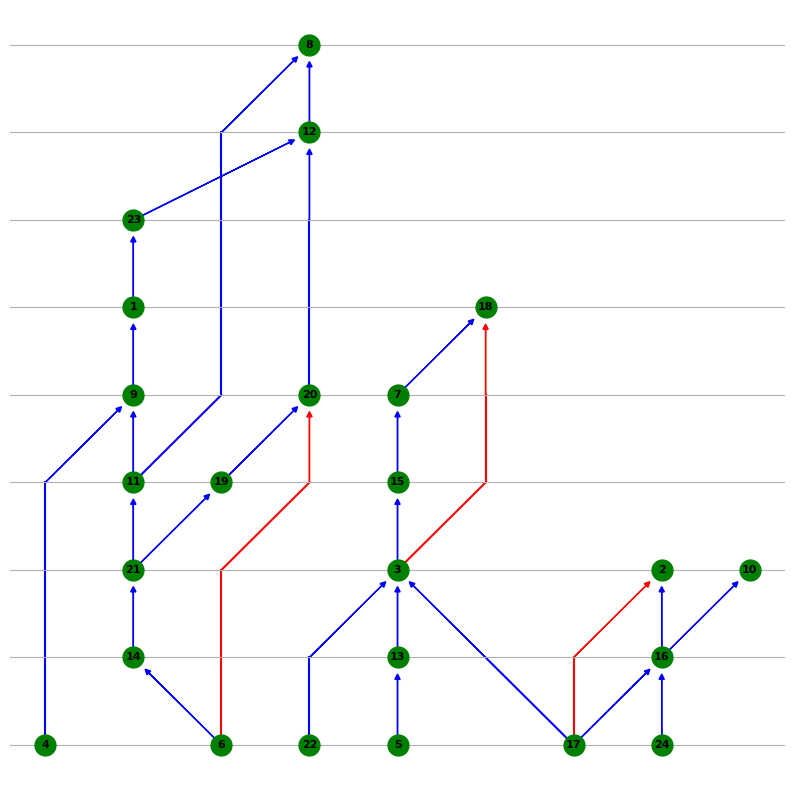

In [72]:
edge_drawing_plot('smallnet.dot',revert=False)

In [73]:
#edge_drawing_plot('smallnet.dot')

In [74]:
#edge_drawing_plot('smallnet.dot',dif_color='blue')

### Step 5

In [75]:
def get_data_step5(dot_file_path, subgraph_names):
    with open(dot_file_path, 'r') as dot_file:
        dot_data = dot_file.read()
    graph = pydot.graph_from_dot_data(dot_data)

    nodes_dict = {}
    edges_list = []

    for subgraph_name in subgraph_names:
        subgraph = None
        for sg in graph[0].get_subgraphs():
            if sg.get_name().strip('"') == subgraph_name:
                subgraph = sg
                break

        if not subgraph:
            print(f"Subgraph '{subgraph_name}' not found.")
            continue

        nodes = subgraph.get_nodes()
        for node in nodes:
            node_id = node.get_name()
            node_attrs = {attr: node.get_attributes()[attr] for attr in node.get_attributes()}
            nodes_dict[node_id] = node_attrs

    # Extracting edges
    edges = graph[0].get_edges()
    for edge in edges:
        source = edge.get_source()
        target = edge.get_destination()
        edge_attrs = {attr: edge.get_attributes()[attr] for attr in edge.get_attributes()}
        edges_list.append((source, target, edge_attrs))

    return nodes_dict, edges_list

dot_file_path = "Datasets/argnet.dot"
subgraph_names = ["Gap in the Sequence of Devonshi"]
nodes_dict, edges_list = get_data_step5(dot_file_path, subgraph_names)
print(nodes_dict)
print(edges_list)


{'n150': {'description': '"The passage between Main Culm and Black Culm Limestone strata is conformable"', 'title': '"Conformable Passage - Main Culm and Black Culm Limestone"', 'type': '"statement-map-node"'}, 'n151': {'description': '"The following passages are conformable: Exmoor and Main Culm, Main Culm and Black Culm Limestone, Black Culm Limestone and the Non-Culm of South Devon"', 'title': '"Conformable Passages - 1"', 'type': '"statement-map-node"'}, 'n152': {'description': '"The following passages are conformable: Main Culm and Black Culm Limestone, Black Culm Limestone and Non-Culm"', 'title': '"Conformable Passages â€“ 2"', 'type': '"statement-map-node"'}, 'n153': {'description': '"The passage between Black Culm Limestone and Non-Culm strata is conformable"', 'title': '"Conformable Passage - Black Culm Limestone and Non-Culm"', 'type': '"statement-map-node"'}, 'n154': {'description': '"The following passages are conformable: Some South Devon limestones and Main Culm, Main Cu

In [76]:
def get_data_step5_bounding(dot_file_path, subgraph_names):
    '''Returns the nodes and edges (both in pydot format) belonging to the specified subgraphs, 
    a list with all the nodes and another with all the edges, 
    and also a dictionary with (edge):weight
    '''
    with open(dot_file_path, 'r') as dot_file:
        dot_data = dot_file.read()
    graph = pydot.graph_from_dot_data(dot_data)

    nodes_dict = {}
    edges_list = []

    for subgraph_name in subgraph_names:
        subgraph = None
        for sg in graph[0].get_subgraphs():
            if sg.get_name().strip('"') == subgraph_name:
                subgraph = sg
                break

        if not subgraph:
            print(f"Subgraph '{subgraph_name}' not found.")
            continue

        nodes = subgraph.get_nodes()
        for node in nodes:
            node_id = node.get_name()
            node_attrs = {attr: node.get_attributes()[attr] for attr in node.get_attributes()}
            node_attrs['subgraph'] = subgraph_name  # Add subgraph name as an attribute
            nodes_dict[node_id] = node_attrs

    # Extracting edges from the entire graph
    edges = graph[0].get_edges()
    for edge in edges:
        source = edge.get_source()
        target = edge.get_destination()
        edge_attrs = {attr: edge.get_attributes()[attr] for attr in edge.get_attributes()}
        edges_list.append((source, target, edge_attrs))

    return nodes_dict, edges_list


Convergence reached! 363


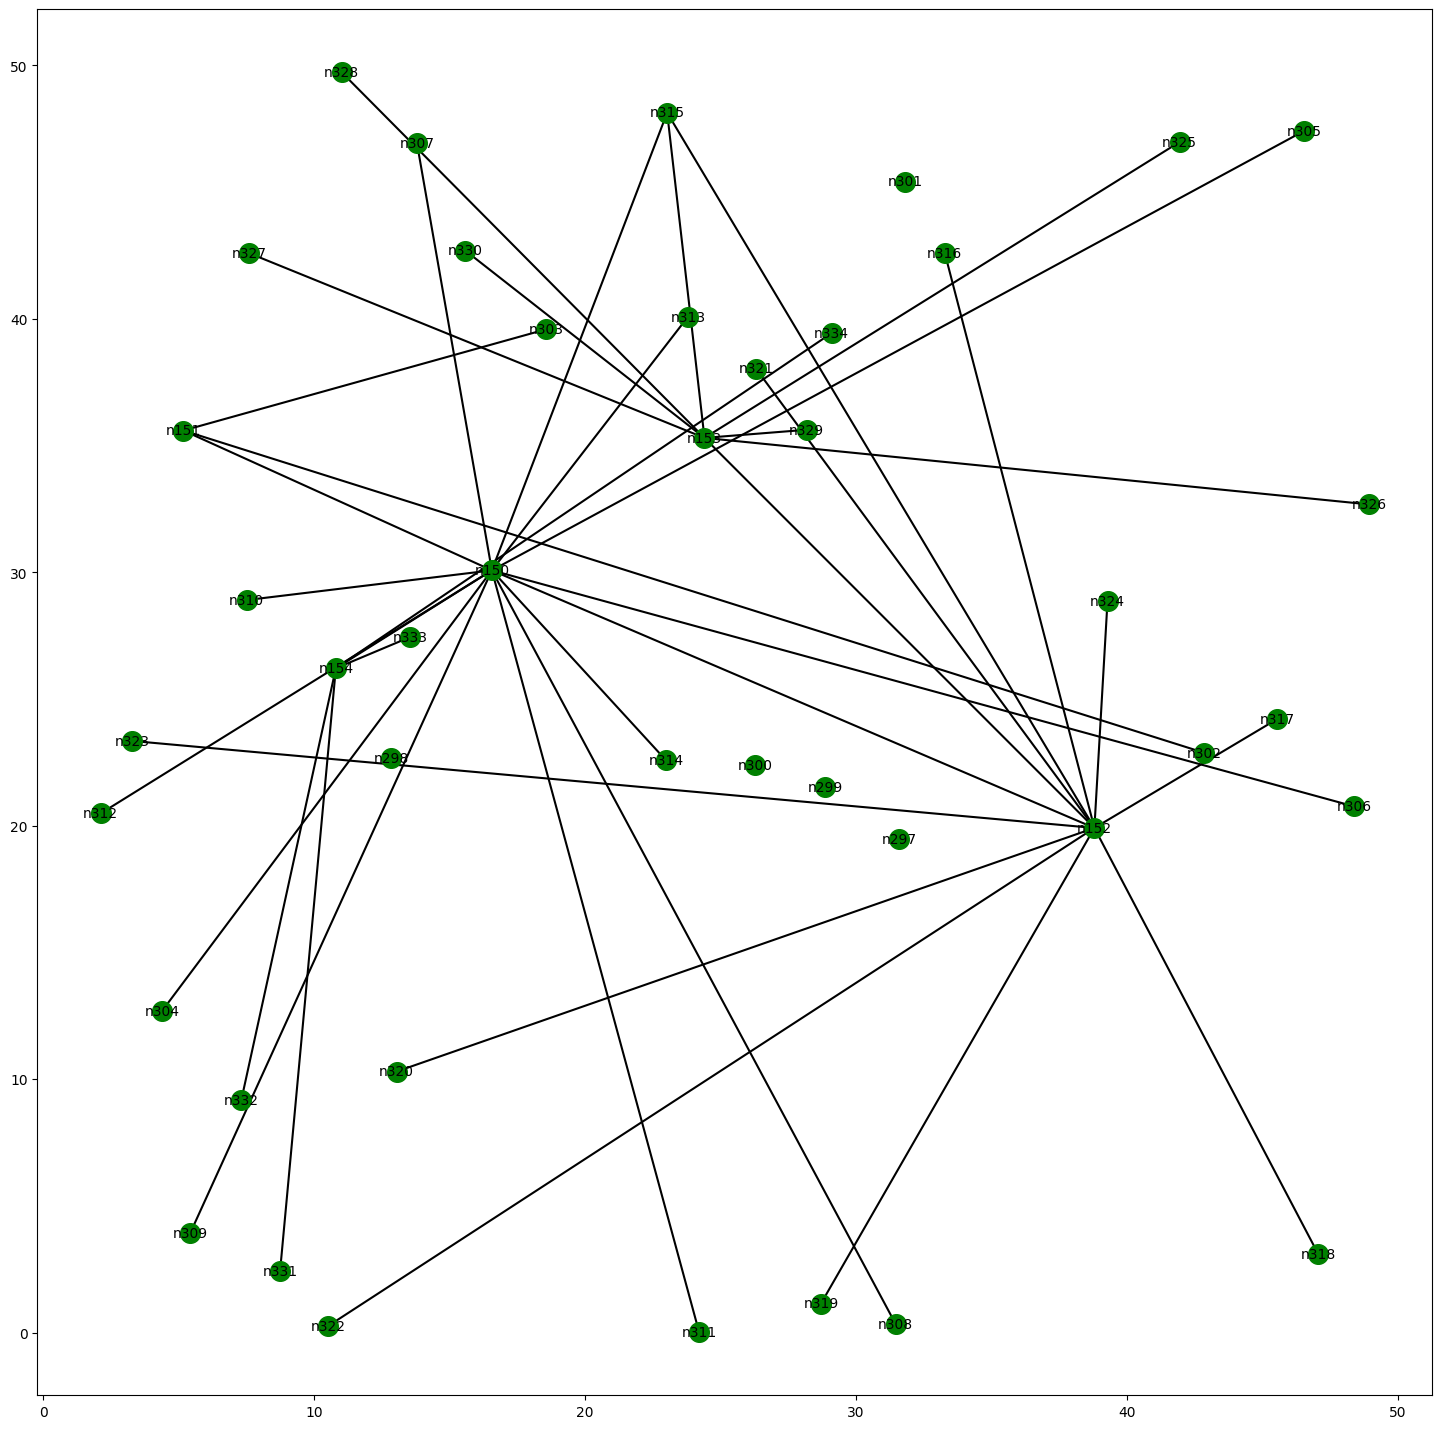

In [77]:
def working_spring_embedder_hugo(file, max_ites=1000, convergence_threshold=0.0001, plot='No', c_spring=2, c_rep=1, l=1, step=0.04):
    nodes, edges = get_data_step5(file, ["Gap in the Sequence of Devonshi"])

    node_positions = {node_id: (random.uniform(0, 50), random.uniform(0, 50)) for node_id in nodes}

    l_changes = []
    ite = 0
    while ite < max_ites:
        changes = []
        for u in nodes:
            force_x = 0
            force_y = 0
            pu = node_positions[u]

            for v in nodes:
                if u != v:
                    pv = node_positions[v]
                    dist = math.sqrt((pu[0] - pv[0]) ** 2 + (pu[1] - pv[1]) ** 2)
                    if dist == 0:
                        dist = 1

                    # Check if both nodes are present in the subgraph
                    if (u, v) in edges or (v, u) in edges:
                        if u in nodes and v in nodes:
                            # Spring
                            constant = c_spring * math.log(dist) / l
                            force_x += (pv[0] - pu[0]) * constant / dist
                            force_y += (pv[1] - pu[1]) * constant / dist
                        else:
                            continue
                    else:
                        # Repulsion
                        constant = c_rep / dist ** 2
                        force_x += (pu[0] - pv[0]) * constant / dist
                        force_y += (pu[1] - pv[1]) * constant / dist
            changes.append(math.sqrt((force_x * step) ** 2 + (force_y * step) ** 2))
            new_x = pu[0] + force_x * step
            new_y = pu[1] + force_y * step
            node_positions[u] = (new_x, new_y)

        average_movement = sum(changes) / len(changes)
        l_changes.append(average_movement)

        if average_movement < convergence_threshold:
            print("Convergence reached!", ite)
            break

        ite += 1
        step *= 0.99

    if plot != 'No':
        plt.figure(figsize=(18, 18))
        for source, target, _ in edges:
            if source in node_positions and target in node_positions:
                start_pos = node_positions[source]
                end_pos = node_positions[target]
                plt.plot([start_pos[0], end_pos[0]], [start_pos[1], end_pos[1]], 'k-', zorder=1)

        for node, pos in node_positions.items():
            plt.scatter(pos[0], pos[1], color='green', s=200, marker='o', zorder=2)
            plt.text(pos[0], pos[1], str(node), fontsize=10, ha='center', va='center')

        plt.gca().set_facecolor('w')
        plt.show()

    return node_positions

layout = working_spring_embedder_hugo('Datasets/argnet.dot', plot='Yes')


## Bounding boxes

Convergence reached! 489


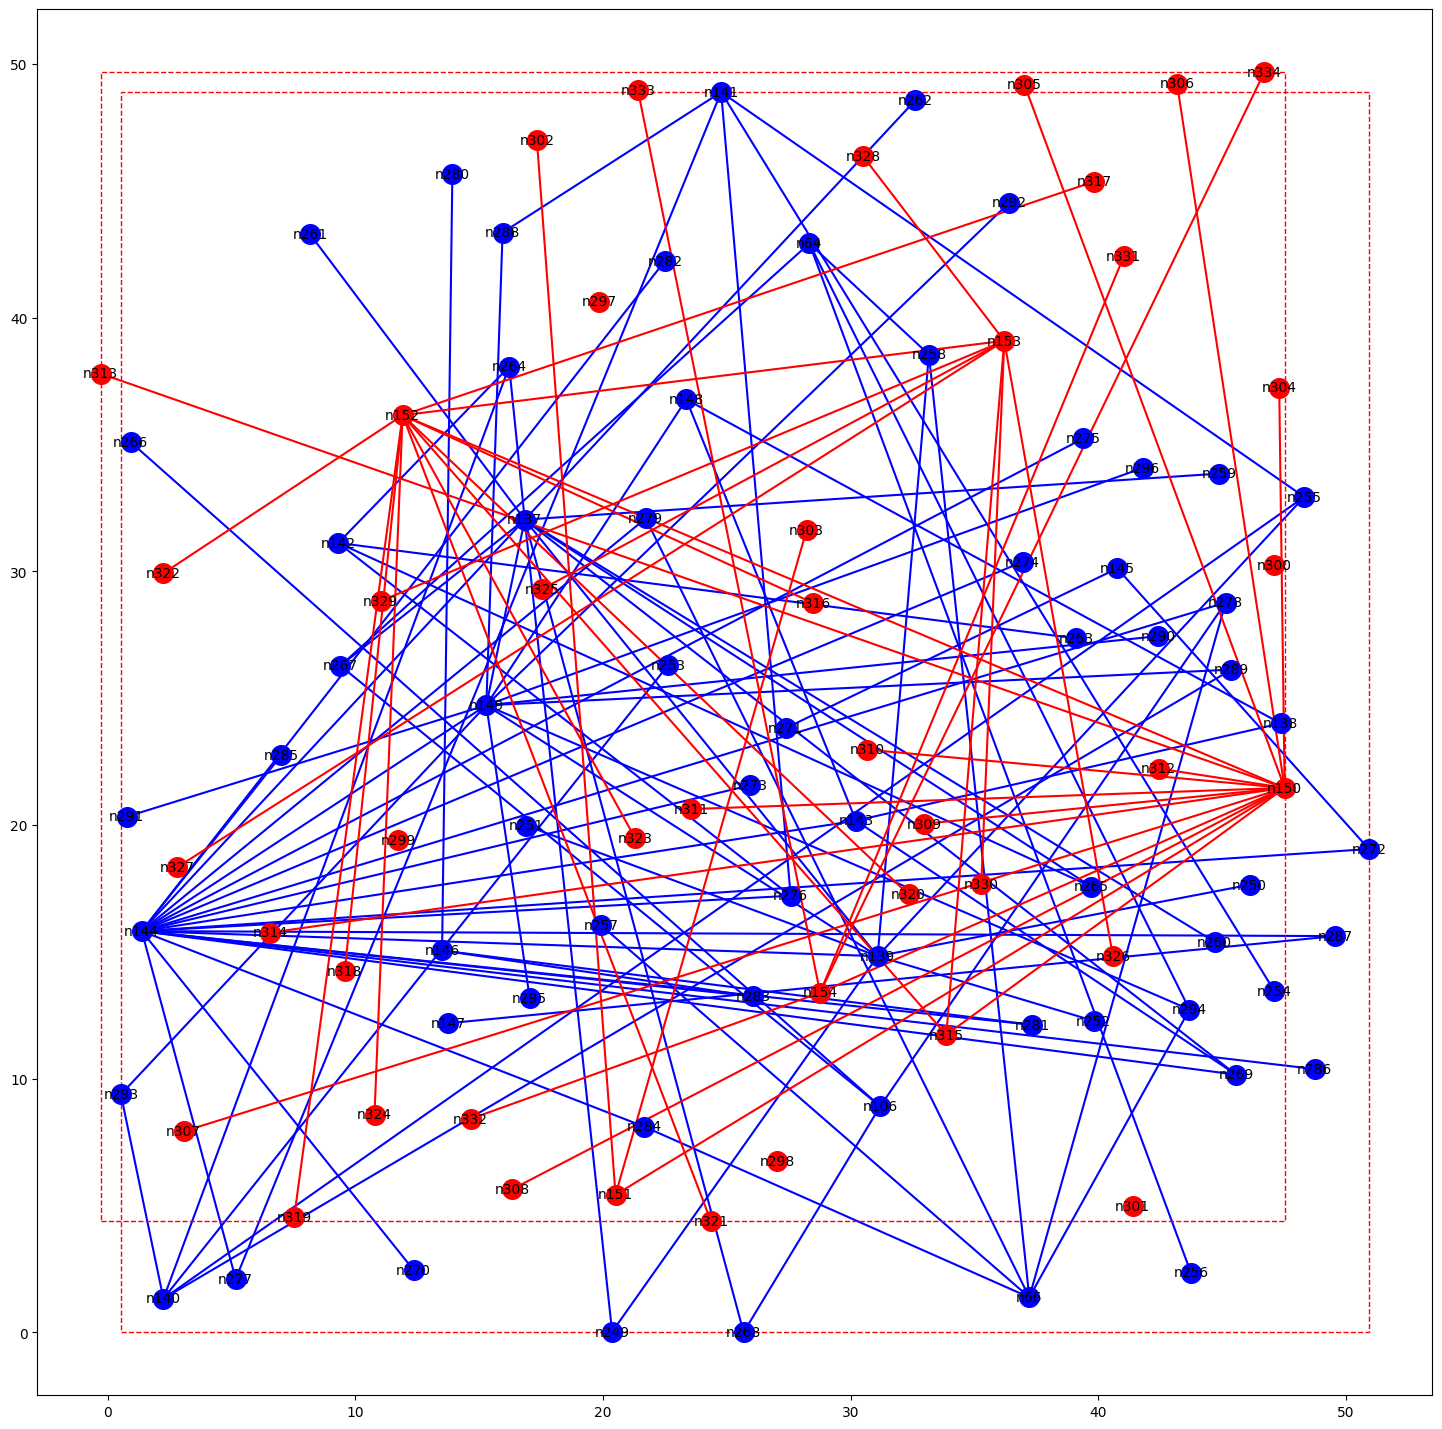

In [78]:
def working_spring_embedder_hugo_bounding(file, max_ites=1000, convergence_threshold=0.00005, plot='No', c_spring=2, c_rep=1, l=1, step=0.04):
    nodes, edges = get_data_step5_bounding(file, ["Youngest Devonian Strata", "Gap in the Sequence of Devonshi"])

    node_positions = {node_id: (random.uniform(0, 50), random.uniform(0, 50)) for node_id in nodes}

    l_changes = []
    ite = 0
    while ite < max_ites:
        changes = []
        for u in nodes:
            force_x = 0
            force_y = 0
            pu = node_positions[u]

            for v in nodes:
                if u != v:
                    pv = node_positions[v]
                    dist = math.sqrt((pu[0] - pv[0]) ** 2 + (pu[1] - pv[1]) ** 2)
                    if dist == 0:
                        dist = 1

                    # Check if both nodes are present in the subgraph
                    if (u, v) in edges or (v, u) in edges:
                        if u in nodes and v in nodes:
                            # Spring
                            constant = c_spring * math.log(dist) / l
                            force_x += (pv[0] - pu[0]) * constant / dist
                            force_y += (pv[1] - pu[1]) * constant / dist
                        else:
                            continue
                    else:
                        # Repulsion
                        constant = c_rep / dist ** 2
                        force_x += (pu[0] - pv[0]) * constant / dist
                        force_y += (pu[1] - pv[1]) * constant / dist
            changes.append(math.sqrt((force_x * step) ** 2 + (force_y * step) ** 2))
            new_x = pu[0] + force_x * step
            new_y = pu[1] + force_y * step
            node_positions[u] = (new_x, new_y)

        average_movement = sum(changes) / len(changes)
        l_changes.append(average_movement)

        if average_movement < convergence_threshold:
            print("Convergence reached!", ite)
            break

        ite += 1
        step *= 0.99

    if plot != 'No':
        plt.figure(figsize=(18, 18))

        #nodes - first subgraph
        for node_id, pos in node_positions.items():
            if nodes[node_id]['subgraph'] == "Youngest Devonian Strata":
                plt.scatter(pos[0], pos[1], color='blue', s=200, marker='o', zorder=2)
                plt.text(pos[0], pos[1], str(node_id), fontsize=10, ha='center', va='center')

        #nodes - second subgraph
        for node_id, pos in node_positions.items():
            if nodes[node_id]['subgraph'] == "Gap in the Sequence of Devonshi":
                plt.scatter(pos[0], pos[1], color='red', s=200, marker='o', zorder=2)
                plt.text(pos[0], pos[1], str(node_id), fontsize=10, ha='center', va='center')

        #edges - first subgraph
        for source, target, _ in edges:
            if source in node_positions and target in node_positions:
                start_pos = node_positions[source]
                end_pos = node_positions[target]
                if nodes[source]['subgraph'] == "Youngest Devonian Strata" and nodes[target]['subgraph'] == "Youngest Devonian Strata":
                    plt.plot([start_pos[0], end_pos[0]], [start_pos[1], end_pos[1]], 'b-', zorder=1)

        #edges - second subgraph
        for source, target, _ in edges:
            if source in node_positions and target in node_positions:
                start_pos = node_positions[source]
                end_pos = node_positions[target]
                if nodes[source]['subgraph'] == "Gap in the Sequence of Devonshi" and nodes[target]['subgraph'] == "Gap in the Sequence of Devonshi":
                    plt.plot([start_pos[0], end_pos[0]], [start_pos[1], end_pos[1]], 'r-', zorder=1)

        # Draw bounding boxes for each subgraph
        for subgraph_name in ["Youngest Devonian Strata", "Gap in the Sequence of Devonshi"]:
            subgraph_nodes = [node_id for node_id, node_data in nodes.items() if node_data['subgraph'] == subgraph_name]
            min_x = min(node_positions[node][0] for node in subgraph_nodes)
            max_x = max(node_positions[node][0] for node in subgraph_nodes)
            min_y = min(node_positions[node][1] for node in subgraph_nodes)
            max_y = max(node_positions[node][1] for node in subgraph_nodes)
            plt.gca().add_patch(plt.Rectangle((min_x, min_y), max_x - min_x, max_y - min_y, fill=False, linestyle='--', color='red'))

        plt.gca().set_facecolor('w')
        plt.show()

    return node_positions

layout = working_spring_embedder_hugo_bounding('Datasets/argnet.dot', plot='Yes')


Convergence reached! 217


KeyError: 'subgraph'

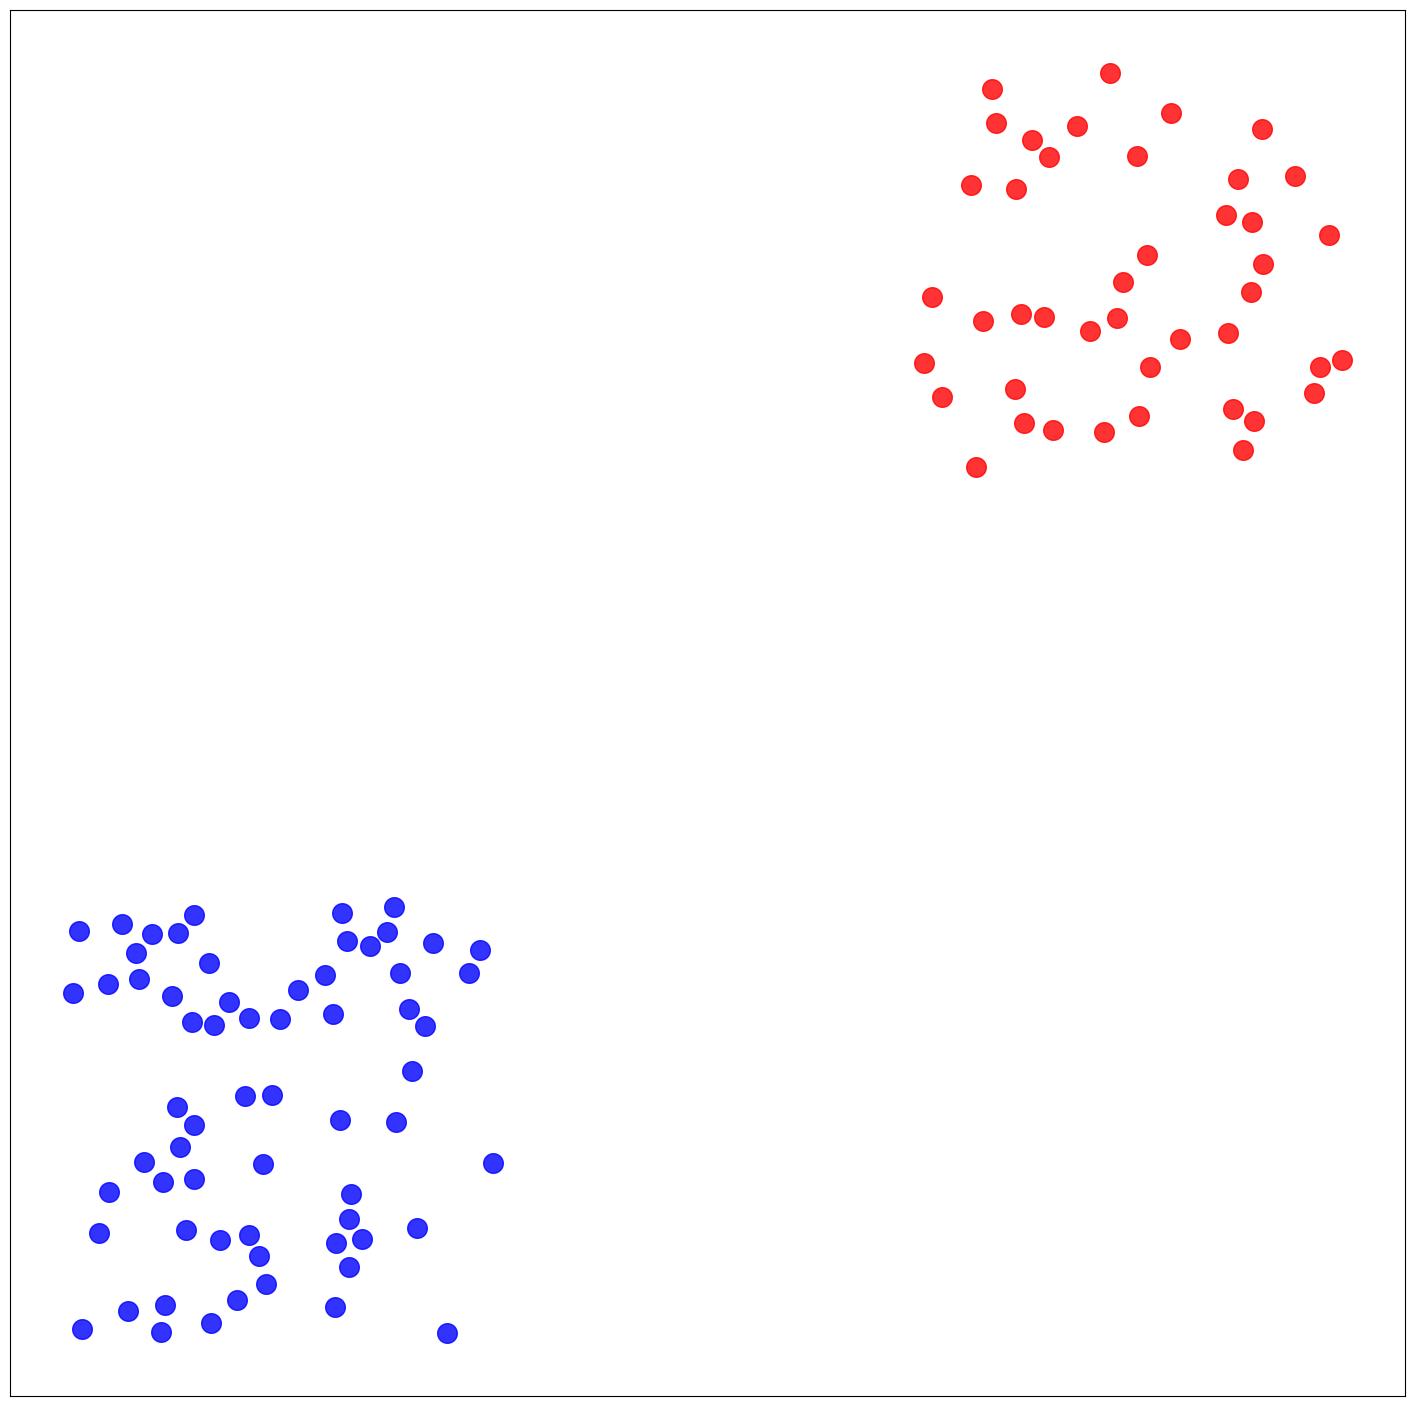

In [100]:
import random
import matplotlib.pyplot as plt
import math

def working_spring_embedder_magnus_bounding(file, max_ites=1000, convergence_threshold=0.00005, plot='No', c_spring=2, c_rep=1, l=1, step=0.04):
    nodes, edges = get_data_step5_bounding(file, ["Youngest Devonian Strata", "Gap in the Sequence of Devonshi"])

    # Initial positions for nodes within each subgraph
    subgraph_positions = {
        "Youngest Devonian Strata": (0, 0),  # Example position for the first subgraph
        "Gap in the Sequence of Devonshi": (100, 100)  # Example position for the second subgraph
    }

    node_positions = {}

    # Assigning initial positions to nodes within each subgraph
    for node_id, node_data in nodes.items():
        subgraph = node_data['subgraph']
        # Randomly perturb initial positions within each subgraph to avoid overlap
        subgraph_x, subgraph_y = subgraph_positions[subgraph]
        node_positions[node_id] = (random.uniform(subgraph_x, subgraph_x + 50), random.uniform(subgraph_y, subgraph_y + 50))

    l_changes = []
    ite = 0
    while ite < max_ites:
        changes = []
        for u in nodes:
            force_x = 0
            force_y = 0
            pu = node_positions[u]

            for v in nodes:
                if u != v:
                    pv = node_positions[v]
                    dist = math.sqrt((pu[0] - pv[0]) ** 2 + (pu[1] - pv[1]) ** 2)
                    if dist == 0:
                        dist = 1

                    # Check if both nodes are present in the subgraph
                    if (u, v) in edges or (v, u) in edges:
                        if u in nodes and v in nodes:
                            # Spring
                            constant = c_spring * math.log(dist) / l
                            force_x += (pv[0] - pu[0]) * constant / dist
                            force_y += (pv[1] - pu[1]) * constant / dist
                        else:
                            continue
                    else:
                        # Repulsion
                        constant = c_rep / dist ** 2
                        force_x += (pu[0] - pv[0]) * constant / dist
                        force_y += (pu[1] - pv[1]) * constant / dist
            changes.append(math.sqrt((force_x * step) ** 2 + (force_y * step) ** 2))
            new_x = pu[0] + force_x * step
            new_y = pu[1] + force_y * step
            node_positions[u] = (new_x, new_y)

        average_movement = sum(changes) / len(changes)
        l_changes.append(average_movement)

        if average_movement < convergence_threshold:
            print("Convergence reached!", ite)
            break

        ite += 1
        step *= 0.99

    if plot != 'No':
        plt.figure(figsize=(18, 18))

        # Plot nodes and edges within each subgraph
        for subgraph_name, color in zip(["Youngest Devonian Strata", "Gap in the Sequence of Devonshi"], ['blue', 'red']):
            subgraph_nodes = [node_id for node_id, node_data in nodes.items() if node_data['subgraph'] == subgraph_name]
            subgraph_edges = [(source, target, weight) for source, target, weight in edges if source in subgraph_nodes and target in subgraph_nodes]
            for node_id, pos in node_positions.items():
                if node_id in subgraph_nodes:
                    plt.scatter(pos[0], pos[1], color=color, s=200, marker='o', zorder=2)
                    plt.text(pos[0], pos[1], str(node_id), fontsize=10, ha='center', va='center')

            for source, target, _ in subgraph_edges:
                start_pos = node_positions[source]
                end_pos = node_positions[target]
                plt.plot([start_pos[0], end_pos[0]], [start_pos[1], end_pos[1]], color=color, linestyle='-', zorder=1)

        # Plot edges between subgraphs
        for source, target, _ in edges:
            if source in node_positions and target in node_positions:
                source_subgraph = nodes[source]['subgraph']
                target_subgraph = nodes[target]['subgraph']
                if source_subgraph != target_subgraph:
                    start_pos = node_positions[source]
                    end_pos = node_positions[target]
                    plt.plot([start_pos[0], end_pos[0]], [start_pos[1], end_pos[1]], color='green', linestyle='--', zorder=1)

        # Draw bounding boxes for each subgraph
        for subgraph_name in ["Youngest Devonian Strata", "Gap in the Sequence of Devonshi"]:
            subgraph_nodes = [node_id for node_id, node_data in nodes.items() if node_data['subgraph'] == subgraph_name]
            min_x = min(node_positions[node][0] for node in subgraph_nodes)
            max_x = max(node_positions[node][0] for node in subgraph_nodes)
            min_y = min(node_positions[node][1] for node in subgraph_nodes)
            max_y = max(node_positions[node][1] for node in subgraph_nodes)
            plt.gca().add_patch(plt.Rectangle((min_x, min_y), max_x - min_x, max_y - min_y, fill=False, linestyle='--', color='red'))

        plt.gca().set_facecolor('w')
        plt.show()

    return node_positions

layout = working_spring_embedder_magnus_bounding('Datasets/argnet.dot', plot='Yes')


# ///////////////////////////// TRASH ///////////////////////////// 

In [79]:
def plot_cross_min1(file,nodes = {},heur='bary'): #Plot cross minimization
    layers,edges = tomas_layer_assignment(file)[0],tomas_layer_assignment(file)[1]
    #if cross_min == 'Yes':
    layers = it_cross_min(file,heur)[0]
    
    #new_file = str(file.split('_')[0]+'.dot')
    invert = heuristic(file)

    if nodes == {}:
        nodes = {}
        for i, layer in enumerate(layers):
            for j, node in enumerate(layer):
                nodes[node] = (j, i)

    fig, ax = plt.subplots()
    for node, coord in nodes.items():
        color = 'grey' if node.startswith('l') else 'brown'
        ax.plot(*coord, marker='o', markersize=10, linestyle='', 
                label='', zorder=2, color=color)  
        if not node.startswith('l'):
            ax.text(*coord, node, ha='center', va='center', fontsize=8, color='black', fontweight='bold')

    

    for edge in edges:
        start_coord = np.array(nodes[edge[0]])
        end_node_center = np.array(nodes[edge[1]])
        direction = end_node_center - start_coord
        direction_normalized = direction / np.linalg.norm(direction)
        end_coord = end_node_center - 0.2 * direction_normalized

        #if edge not in invert:#(edge[1],edge[0]) not in invert:
        ax.arrow(*start_coord,*(end_coord - start_coord),head_width=0.06,head_length=0.06,fc='blue',ec='blue',zorder=1)
        #else:
        #    ax.arrow(*start_coord,*(end_coord - start_coord),head_width=0.06, head_length=0.06,fc='red',ec='red',zorder=1)
        
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.tick_params(axis='both', which='both', bottom=False, left=False)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.yaxis.grid(True)
    plt.show()

#plot_cross_min1('smallnet.dot')

In [80]:
def plot_layer_assignment1(file,nodes = {}): #Plot cross minimization
    layers,edges = tomas_layer_assignment(file)[0],tomas_layer_assignment(file)[1]
    #if cross_min == 'Yes':
    #layers = it_cross_min(file,heur)[0]
    
    #new_file = str(file.split('.')[0]+'_acyc.dot')
    #invert = heuristic(new_file)

    if nodes == {}:
        nodes = {}
        for i, layer in enumerate(layers):
            for j, node in enumerate(layer):
                nodes[node] = (j, i)

    fig, ax = plt.subplots()
    for node, coord in nodes.items():
        color = 'grey' if node.startswith('l') else 'brown'
        ax.plot(*coord, marker='o', markersize=10, linestyle='', 
                label='', zorder=2, color=color)  
        if not node.startswith('l'):
            ax.text(*coord, node, ha='center', va='center', fontsize=8, color='black', fontweight='bold')

    

    for edge in edges:
        start_coord = np.array(nodes[edge[0]])
        end_node_center = np.array(nodes[edge[1]])
        direction = end_node_center - start_coord
        direction_normalized = direction / np.linalg.norm(direction)
        end_coord = end_node_center - 0.2 * direction_normalized

        #if edge not in invert:#(edge[1],edge[0]) not in invert:
        ax.arrow(*start_coord,*(end_coord - start_coord),head_width=0.06,head_length=0.06,fc='blue',ec='blue',zorder=1)
        #else:
        #    ax.arrow(*start_coord,*(end_coord - start_coord),head_width=0.06, head_length=0.06,fc='red',ec='red',zorder=1)
        
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.tick_params(axis='both', which='both', bottom=False, left=False)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.yaxis.grid(True)
    plt.show()

#plot_layer_assignment1('smallnet.dot')

In [81]:
def final_plot1(file,nodes = {},heur='bary'):
    layers,edges = tomas_layer_assignment(file)[0],tomas_layer_assignment(file)[1]
    layers = it_cross_min(file,heur)[0]
    
    #new_file = str(file.split('_')[0]+'.dot')
    #invert = heuristic(new_file)
    r
    inverted = find_inverted(file)
    print(inverted)
    if nodes == {}:
        nodes = {}
        for i, layer in enumerate(layers):
            for j, node in enumerate(layer):
                nodes[node] = (j, i)

    fig, ax = plt.subplots()
    for node, coord in nodes.items():
        color = 'red'
        
        if not node.startswith('l'):
            ax.plot(*coord, marker='o', markersize=10, linestyle='', label='', zorder=2, color=color)  
            ax.text(*coord, node, ha='center', va='center', fontsize=8, color='black', fontweight='bold')

    

    for edge in edges:
        #arrows
        if (edge[0].startswith('l') and not(edge[1].startswith('l'))) or (not(edge[0].startswith('l') or edge[1].startswith('l'))):
            # start_coord = np.array(nodes[edge[0]])
            # end_node_center = np.array(nodes[edge[1]])
            # direction = end_node_center - start_coord
            # direction_normalized = direction / np.linalg.norm(direction)
            # end_coord = end_node_center - 0.25 * direction_normalized
            if edge in inverted:
                start_coord = np.array(nodes[edge[1]])
                end_node_center = np.array(nodes[edge[0]])
                direction = end_node_center - start_coord
                direction_normalized = direction / np.linalg.norm(direction)
                end_coord = end_node_center - 0.25 * direction_normalized
                ax.arrow(*start_coord,*(end_coord - start_coord),head_width=0.06,head_length=0.06,fc='red',ec='red',zorder=1)
            else:
                start_coord = np.array(nodes[edge[0]])
                end_node_center = np.array(nodes[edge[1]])
                direction = end_node_center - start_coord
                direction_normalized = direction / np.linalg.norm(direction)
                end_coord = end_node_center - 0.25 * direction_normalized
                ax.arrow(*start_coord,*(end_coord - start_coord),head_width=0.06,head_length=0.06,fc='blue',ec='blue',zorder=1)
        
        #edges
        else:
            start_coord = np.array(nodes[edge[0]])
            end_node_center = np.array(nodes[edge[1]])
            if edge in inverted:
                ax.plot([start_coord[0] , end_node_center[0]], [start_coord[1] , end_node_center[1]], color='red', linestyle='-',zorder=1)
            else:
                ax.plot([start_coord[0] , end_node_center[0]], [start_coord[1] , end_node_center[1]], color='blue', linestyle='-',zorder=1)

    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.tick_params(axis='both', which='both', bottom=False, left=False)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.yaxis.grid(True)
    plt.show()
    #print(it_cross_min(file,heur)[1

In [82]:
def final_plot2(file,nodes = {},heur='bary',revert= True):
    layers,edges = tomas_layer_assignment(file)[0],tomas_layer_assignment(file)[1]
    layers = it_cross_min(file,heur)[0]
    
    inverted = find_inverted(file)
    reverted = [(edge[1],edge[0]) for edge in inverted]

    if nodes == {}:
        nodes = {}
        for i, layer in enumerate(layers):
            for j, node in enumerate(layer):
                nodes[node] = (j, i)

    fig, ax = plt.subplots()
    for node, coord in nodes.items():
        color = 'red'
        if not node.startswith('l'):
            ax.plot(*coord, marker='o', markersize=10, linestyle='', label='', zorder=2, color=color)  
            ax.text(*coord, node, ha='center', va='center', fontsize=8, color='black', fontweight='bold')

    for edge in edges:
        if revert == False:
            #arrows
            if (edge[0].startswith('l') and not(edge[1].startswith('l'))) or (not(edge[0].startswith('l') or edge[1].startswith('l'))):
                start_coord = np.array(nodes[edge[0]])
                end_node_center = np.array(nodes[edge[1]])
                direction = end_node_center - start_coord
                direction_normalized = direction / np.linalg.norm(direction)
                end_coord = end_node_center - 0.25 * direction_normalized
                if edge in inverted:
                    ax.arrow(*start_coord,*(end_coord - start_coord),head_width=0.06,head_length=0.06,fc='red',ec='red',zorder=1)
                else:
                    ax.arrow(*start_coord,*(end_coord - start_coord),head_width=0.06,head_length=0.06,fc='blue',ec='blue',zorder=1)
            
            #edges
            else:
                start_coord = np.array(nodes[edge[0]])
                end_node_center = np.array(nodes[edge[1]])
                if edge in inverted:
                    ax.plot([start_coord[0] , end_node_center[0]], [start_coord[1] , end_node_center[1]], color='red', linestyle='-',zorder=1)
                else:
                    ax.plot([start_coord[0] , end_node_center[0]], [start_coord[1] , end_node_center[1]], color='blue', linestyle='-',zorder=1)
        #reversed edges back to original position
        else:
            new_edge = (edge[1],edge[0])
            if (new_edge[0].startswith('l') and not(new_edge[1].startswith('l'))) or (not(new_edge[0].startswith('l') or new_edge[1].startswith('l'))):
                start_coord = np.array(nodes[new_edge[0]])
                end_node_center = np.array(nodes[new_edge[1]])
                direction = end_node_center - start_coord
                direction_normalized = direction / np.linalg.norm(direction)
                end_coord = end_node_center - 0.25 * direction_normalized
                if edge in inverted:
                    ax.arrow(*start_coord,*(end_coord - start_coord),head_width=0.06,head_length=0.06,fc='red',ec='red',zorder=1)
                else:
                    ax.arrow(*start_coord,*(end_coord - start_coord),head_width=0.06,head_length=0.06,fc='blue',ec='blue',zorder=1)
            
            #edges
            else:
                start_coord = np.array(nodes[edge[0]])
                end_node_center = np.array(nodes[edge[1]])
                if edge in inverted:
                    ax.plot([start_coord[0] , end_node_center[0]], [start_coord[1] , end_node_center[1]], color='red', linestyle='-',zorder=1)
                else:
                    ax.plot([start_coord[0] , end_node_center[0]], [start_coord[1] , end_node_center[1]], color='blue', linestyle='-',zorder=1)

    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.tick_params(axis='both', which='both', bottom=False, left=False)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.yaxis.grid(True)
    plt.show()
    #print(it_cross_min(file,heur)[1]) 

working cross min with both bary and median

In [83]:
def c_uv(u,v,edges,layer):
    '''u and v are nodes from layer i+1, and we want to see the number of crossing when we look at they're parents
    in layer i
    '''
    u_parents = [(parent,layer.index(parent)) for parent in layer if parent in parent_nodes(edges,u)[1]]
    v_parents = [(parent,layer.index(parent)) for parent in layer if parent in parent_nodes(edges,v)[1]]
    ans = 0
    for u_parent in u_parents:
        for v_parent in v_parents:
            if u_parent[0] != v_parent[0] and u_parent[1] > v_parent[1]:
                ans += 1
    return ans#u_parents, v_parents

# nodes, edges, node_list, edge_list, weights = get_data('heuristic_acyc.dot')[0], get_data('heuristic_acyc.dot')[1], get_data('heuristic_acyc.dot')[2], get_data('heuristic_acyc.dot')[3], get_data('heuristic_acyc.dot')[4]
# print(edge_list)
# layers = tomas_layer_assignment('heuristic_acyc.dot')[0]
# edge_list = tomas_layer_assignment('heuristic_acyc.dot')[1]
# print(c_uv('5','l1_2_1',edge_list, layers[0]))

def cr(edges,layer1,layer2):
    '''Returns the total number of crossing between layer1 and layer2
    '''
    ans = 0
    for u in layer2:
        for v in layer2:
            if layer2.index(v)>layer2.index(u):
                ans+= c_uv(u,v,edges,layer1)
    return ans

#print(cr(edge_list,layers[2],layers[3]))

def bary(node,edges,layers,layer):
    ans = 0
    parents = parent_nodes(edges,node)[1]
    childs = child_nodes(edges,node)[1]
    #print('node-',node, 'parents',parents)
    for parent in parents:
        #print(layer.index(parent))
        #print(parent)
        ans+= int(layers[layer-1].index(parent))
    #den = 1
    #if len(parents) != 0:
    den = len(parents)+len(childs)
    return ans/den

def median(node, edges,layers,layer):
    ans = 0
    #print('layer',layer)
    neighbours = parent_nodes(edges,node)[1]
    #print('neighbours',neighbours)
    prev_layer = layers[layer-1]
    #print('prev_layer',prev_layer)
    coordinates = [prev_layer.index(neighbour) for neighbour in neighbours]
    o = sorted(coordinates)
    #print('order',o)

    if neighbours != []:
        ans = o[len(o)//2] if len(o)%2 !=0 else o[len(o)//2-1]
    return ans


#layers,edges = it_cross_min('heuristic_acyc.dot'), tomas_layer_assignment('heuristic_acyc.dot')[1]#layers, edges
# #print(layers)
#print(median('8',edges,layers,3))

def it_cross_min3(file, heur='bary'):
    layers, edges = tomas_layer_assignment(file)[0], tomas_layer_assignment(file)[1]
    initial_crs = 0
    for i in range(1, len(layers)):
        initial_crs += cr(edges, layers[i-1], layers[i])
    final_layers = {}
    ans = initial_crs
    if heur == 'bary':
        crs = []
        for j in range(len(layers)**3):
            old_layers = layers[:]
            new_layers = []
            crs.append([])
            while new_layers != old_layers:
                old_layers = layers[:]
                random.shuffle(old_layers[0])
                for i in range(len(old_layers)):
                    layer_i = old_layers[i]
                    barycenters = sorted([(node, bary(node, edges, old_layers, i)) for node in layer_i], key=lambda x: x[1])
                    #[('2', 0.0), ('12', 0.0), ('7', 0.0)]
                    old_layers[i] = [node[0] for node in barycenters]
                    #['2','12','7']
                for i in range(len(old_layers)-1, -1, -1):
                    layer_i = old_layers[i]
                    barycenters = sorted([(node, bary(node, edges, old_layers, i)) for node in layer_i], key=lambda x: x[1])
                    old_layers[i] = [node[0] for node in barycenters]
                new_layers = old_layers
            for i in range(len(new_layers)):
                crs[j].append(cr(edges, new_layers[i-1], new_layers[i]))
            final_layers[sum(crs[j])] = new_layers[:]
        

    if heur == 'median':
        crs = []
        for x in range(len(layers)**3):
            old_layers = layers[:]
            new_layers = []
            crs.append([])
            while new_layers != old_layers:
                old_layers = layers[:]
                random.shuffle(old_layers[0])
                for i in range(len(old_layers)):
                    ##print('########### layer',i,'###########')
                    layer_i = old_layers[i]
                    medians = sorted([(node, median(node, edges, old_layers, i)) for node in layer_i], key=lambda x: x[1])
                    #[('2', 0), ('7', 0), ('12', 0)]
                    done_orders = [medians[0][1]]
                    #print('inital medians',medians)
                    #print('inital done order',done_orders)
                    #print('###########')
                    for j in range(1,len(medians)):
                    #     node,order = medians[i]
                    #     if order == medians[i-1][]
                        
                        node,order = medians[j]
                        #print('node',node, 'order',order)
                        #print('done orders:',done_orders)
                        if order not in done_orders:
                            done_orders.append(order)
                            #print('just add')
                            #print(medians[:j])
                        else:
                            #print('need to change')
                            u_parents = parent_nodes(edges,node)
                            v_parents = parent_nodes(edges,medians[j-1])
                            if (len(u_parents)%2==0 and len(v_parents)%2!=0) or (len(u_parents)%2!=0 and len(v_parents)%2==0):
                                left = node if len(u_parents)%2!=0 else medians[j-1]
                                right = node if len(u_parents)%2==0 else medians[j-1]
                                medians[j-1] = (left,j-1)
                                medians[j] = (right,j)
                            else:
                                medians[j] = (node,j)
                            #print(medians[:j+1])
                            done_orders.append(j)
                        #print('###########')
                    #print(medians)
                    old_layers[i] = [node[0] for node in medians]
                    
                for i in range(len(old_layers)-1, -1, -1):
                    layer_i = old_layers[i]
                    medians = sorted([(node, median(node, edges, old_layers, i)) for node in layer_i], key=lambda x: x[1])
                    done_orders = [medians[0][1]]
                    #print('inital medians',medians)
                    #print('inital done order',done_orders)
                    #print('###########')
                    for j in range(1,len(medians)):
                    #     node,order = medians[i]
                    #     if order == medians[i-1][]
                        
                        node,order = medians[j]
                        #print('node',node, 'order',order)
                        #print('done orders:',done_orders)
                        if order not in done_orders:
                            done_orders.append(order)
                            #print('just add')
                            #print(medians[:j])
                        else:
                            #print('need to change')
                            u_parents = parent_nodes(edges,node)
                            v_parents = parent_nodes(edges,medians[j-1])
                            if (len(u_parents)%2==0 and len(v_parents)%2!=0) or (len(u_parents)%2!=0 and len(v_parents)%2==0):
                                left = node if len(u_parents)%2!=0 else medians[j-1]
                                right = node if len(u_parents)%2==0 else medians[j-1]
                                medians[j-1] = (left,j-1)
                                medians[j] = (right,j)
                            else:
                                medians[j] = (node,j)
                            #print(medians[:j+1])
                            done_orders.append(j)
                        #print('###########')
                    old_layers[i] = [node[0] for node in medians]
                new_layers = old_layers
            for i in range(len(new_layers)):
                crs[x].append(cr(edges, new_layers[i-1], new_layers[i]))
            final_layers[sum(crs[x])] = new_layers[:]
    minimum = min(final_layers.keys())
    #print(minimum)
    return final_layers[minimum],minimum

# ans_layers,minimum = it_cross_min3('heuristic_acyc.dot',heur='median')
# print('final layers',ans_layers)
# print('min',minimum)

working cross min with only bary

In [84]:
def c_uv(u,v,edges,layer):
    '''u and v are nodes from layer i+1, and we want to see the number of crossing when we look at they're parents
    in layer i
    '''
    u_parents = [(parent,layer.index(parent)) for parent in layer if parent in parent_nodes(edges,u)[1]]
    v_parents = [(parent,layer.index(parent)) for parent in layer if parent in parent_nodes(edges,v)[1]]
    ans = 0
    for u_parent in u_parents:
        for v_parent in v_parents:
            if u_parent[0] != v_parent[0] and u_parent[1] > v_parent[1]:
                ans += 1
    return ans#u_parents, v_parents

# nodes, edges, node_list, edge_list, weights = get_data('heuristic_acyc.dot')[0], get_data('heuristic_acyc.dot')[1], get_data('heuristic_acyc.dot')[2], get_data('heuristic_acyc.dot')[3], get_data('heuristic_acyc.dot')[4]
# print(edge_list)
# layers = tomas_layer_assignment('heuristic_acyc.dot')[0]
# edge_list = tomas_layer_assignment('heuristic_acyc.dot')[1]
# print(c_uv('5','l1_2_1',edge_list, layers[0]))

def cr(edges,layer1,layer2):
    '''Returns the total number of crossing between layer1 and layer2
    '''
    ans = 0
    for u in layer2:
        for v in layer2:
            if layer2.index(v)>layer2.index(u):
                ans+= c_uv(u,v,edges,layer1)
    return ans

#print(cr(edge_list,layers[2],layers[3]))

def bary(node,edges,layers,layer):
    ans = 0
    parents = parent_nodes(edges,node)[1]
    childs = child_nodes(edges,node)[1]
    #print('node-',node, 'parents',parents)
    for parent in parents:
        #print(layer.index(parent))
        #print(parent)
        ans+= int(layers[layer-1].index(parent))
    #den = 1
    #if len(parents) != 0:
    den = len(parents)+len(childs)
    return ans/den

def median(node, edges,layers,layer):
    ans = 0
    #print('layer',layer)
    neighbours = parent_nodes(edges,node)[1]
    #print('neighbours',neighbours)
    prev_layer = layers[layer-1]
    #print('prev_layer',prev_layer)
    coordinates = [prev_layer.index(neighbour) for neighbour in neighbours]
    o = sorted(coordinates)
    #print('order',o)

    if neighbours != []:
        ans = o[len(o)//2] if len(o)%2 !=0 else o[len(o)//2-1]
    return ans


#layers,edges = it_cross_min('heuristic_acyc.dot'), tomas_layer_assignment('heuristic_acyc.dot')[1]#layers, edges
# #print(layers)
#print(median('8',edges,layers,3))

def it_cross_min2(file, heur='bary'):
    layers, edges = tomas_layer_assignment(file)[0], tomas_layer_assignment(file)[1]
    initial_crs = 0
    for i in range(1, len(layers)):
        initial_crs += cr(edges, layers[i-1], layers[i])
    final_layers = {}
    ans = initial_crs
    if heur == 'bary':
        crs = []
        for j in range(len(layers)**3):
            old_layers = layers[:]
            new_layers = []
            crs.append([])
            while new_layers != old_layers:
                old_layers = layers[:]
                random.shuffle(old_layers[0])
                for i in range(len(old_layers)):
                    layer_i = old_layers[i]
                    barycenters = sorted([(node, bary(node, edges, old_layers, i)) for node in layer_i], key=lambda x: x[1])
                    #[('2', 0.0), ('12', 0.0), ('7', 0.0)]
                    old_layers[i] = [node[0] for node in barycenters]
                    #['2','12','7']
                for i in range(len(old_layers)-1, -1, -1):
                    layer_i = old_layers[i]
                    barycenters = sorted([(node, bary(node, edges, old_layers, i)) for node in layer_i], key=lambda x: x[1])
                    old_layers[i] = [node[0] for node in barycenters]
                new_layers = old_layers
            for i in range(len(new_layers)):
                crs[j].append(cr(edges, new_layers[i-1], new_layers[i]))
            final_layers[sum(crs[j])] = new_layers[:]
            #print(sum(crs[j]),crs[j],final_layers[sum(crs[j])])
        

    if heur == 'median':
        crs = []
        for j in range(len(layers)**3):
            old_layers = layers[:]
            new_layers = []
            crs.append([])
            while new_layers != old_layers:
                old_layers = layers[:]
                random.shuffle(old_layers[0])
                for i in range(len(old_layers)):
                    layer_i = old_layers[i]
                    medians = sorted([(node, median(node, edges, old_layers, i)) for node in layer_i], key=lambda x: x[1])
                    #[('2', 0), ('7', 0), ('12', 0)]
                    old_layers[i] = [node[0] for node in medians]
                    
                for i in range(len(old_layers)-1, -1, -1):
                    layer_i = old_layers[i]
                    medians = sorted([(node, median(node, edges, old_layers, i)) for node in layer_i], key=lambda x: x[1])
                    old_layers[i] = [node[0] for node in medians]
                new_layers = old_layers
            for i in range(len(new_layers)):
                crs[j].append(cr(edges, new_layers[i-1], new_layers[i]))
            final_layers[sum(crs[j])] = new_layers[:]
    minimum = min(final_layers.keys())
    #print(minimum)
    return final_layers[minimum],minimum

# ans_layers,minimum = it_cross_min2('heuristic_acyc.dot',heur='median')
# print('final layers',ans_layers)
# print('min',minimum)

In [85]:
def it_cross_min2(file,heur = 'Bary'):
    #1
    layers,edges = tomas_layer_assignment(file)[0],tomas_layer_assignment(file)[1]
    initial_crs = 0
    for i in range(1,len(layers)):
        initial_crs += cr(edges,layers[i-1],layers[i])
    final_layers = {}
    ans = initial_crs
    if heur == 'Bary':
        crs=[]
        for j in range(len(layers)**3):
            #print('#############',str(j),'#############')
            old_layers = layers
            new_layers = []
            #print(layers)
            #print('first layer:',layers[0])
            crs.append([])
            while new_layers != old_layers:
                #changes = 0
                old_layers = layers
                random.shuffle(old_layers[0])
                #print('old:',old_layers)
                new_layers = []# layers
                #print('#######2######')
                for i in range(0,len(old_layers)):
                    layer_i = old_layers[i]
                    barycenters = sorted([(node,bary(node,edges,old_layers,i)) for node in layer_i], key=lambda x: x[1])
                    #print(i,barycenters)
                    old_layers[i] = [node[0] for node in barycenters]
                
                #print('#######3######')
                for i in range(len(old_layers)-1,-1,-1):
                    layer_i = old_layers[i]
                    barycenters = sorted([(node,bary(node,edges,old_layers,i)) for node in layer_i], key=lambda x: x[1])
                    #print(i,barycenters)
                    old_layers[i] = [node[0] for node in barycenters]
                #print(new_layers)
                new_layers = old_layers
                #print('new',new_layers)
            #print('final layers:',new_layers)
            for i in range(0,len(new_layers)):
                crs[j].append(cr(edges,new_layers[i-1],new_layers[i]))
            #print(sum(crs[j]))
            #print('sum:',sum(crs[j]))
            #print(sum(crs[j]),crs[j],new_layers)
            #print()
            
            final_layers[sum(crs[j])] = new_layers
            print(sum(crs[j]),final_layers[sum(crs[j])])
            # if sum(crs[j]) < ans:
            #     final_layer=new_layers
            #     print('better',final_layer)
            #     ans = sum(crs[j])
        #print(final_layers)
        minimum = min(final_layers.keys())#, key=lambda x: x[1])
        #print('last',final_layers)
        print('minimum',minimum)
        return minimum,final_layers[minimum]#,new_layers#,crs


# print(layers)
# print(edge_list)
#print(it_cross_min(layers,edge_list))


#layers, edges = tomas_layer_assignment('heuristic_acyc.dot')
#plot_layer_assignment('heuristic_acyc.dot')

# ans_layers = it_cross_min2('heuristic_acyc.dot')
# #print('final cr',ans)
# print('final layers',ans_layers)


In [86]:
def fruchterman_reingold(file, max_ites=1000, plot='No', c=2, dim =20, convergence_threshold=0.005): 
    nodes, edges, node_list, edge_list, weights = get_data(file)[0], get_data(file)[1], get_data(file)[2], get_data(file)[3], get_data(file)[4]
    node_positions = {node.get_name(): (random.uniform(0, 50), random.uniform(0, 50)) for node in nodes}

    l = c*math.sqrt(dim*dim/len(node_list)) 
    print(l)
    l_changes = []
    ite = 0
    while ite < max_ites:
        changes = []
        for u in nodes:
            force_x = 0
            force_y = 0
            pu = node_positions[u.get_name()]

            for v in nodes:
                if u.get_name() != v.get_name():
                    pv = node_positions[v.get_name()]
                    dist = math.sqrt((pu[0]-pv[0])**2 + (pu[1]-pv[1])**2)
                    if dist == 0:
                        dist = 1

                    # Spring
                    if (u.get_name(), v.get_name()) in edge_list or (v.get_name(), u.get_name()) in edge_list:
                        constant = dist**2/l
                        print(constant)
                        force_x += (pv[0]-pu[0])*constant/dist
                        force_y += (pv[1]-pu[1])*constant/dist
                    # Repulsion
                    
                    constant = l**2/dist
                    print(constant)
                    force_x += (pu[0]-pv[0])*constant/dist
                    force_y += (pu[1]-pv[1])*constant/dist
                changes.append(math.sqrt((force_x*0.01)**2 + (force_y*0.01)**2))
                new_x = pu[0] + force_x*0.01
                new_y = pu[1] + force_y*0.01
                node_positions[u.get_name()] = (new_x,new_y)

        average_movement = sum(changes) / len(changes)
        l_changes.append(average_movement)
        
        
        if average_movement < convergence_threshold:
            print("convergence signal!!!", ite) 
            break
        
        ite += 1

    if plot != 'No':
        plt.figure(figsize=(18, 18))         
        for edge in edges:
            start_node = edge.get_source()
            end_node = edge.get_destination()
            position = str(str(edge.get_attributes())).rfind(':')
            if int(position) != -1:
                w = int(str(edge.get_attributes())[position+3:-2])
                if w != 1:
                    w = w/10
            start_pos = node_positions[start_node]
            end_pos = node_positions[end_node]
            plt.plot([start_pos[0], end_pos[0]], [start_pos[1], end_pos[1]], 'k-',linewidth=w,zorder = 1) 

        for node, pos in node_positions.items():
            plt.scatter(pos[0], pos[1], color='green', s=200, marker='o', zorder =2)  # vse marker='o' for circle markers
            plt.text(pos[0], pos[1], str(node), fontsize=10, ha='center', va='center')
        #plt.axis('off')
        plt.gca().set_facecolor('w')
        #plt.savefig('Plots/'+tree+'_'+layovt+'_plot.png')
        plt.show()


    return node_positions, l_changes


#l_f_v = fruchterman_reingold('Datasets/LesMiserables.dot', max_ites=1000, plot='Yes')

In [87]:
def working_spring_embedder(file, ite, plot='No', c_spring=2, c_rep=1, l=1):
    nodes, edges, node_list, edge_list, weights = get_data(file)[0], get_data(file)[1], get_data(file)[2], get_data(file)[3], get_data(file)[4]
    node_positions = {node.get_name(): (random.uniform(0, 50), random.uniform(0, 50)) for node in nodes} #Randomly initialize the positions of nodes.

    l_changes = []
    for _ in range(ite): #here maybe using convergence criteria instead of implementing  a certain number of interactions
        changes = []
        for u in nodes:
            force_x = 0
            force_y = 0
            pu = node_positions[u.get_name()]

            for v in nodes:
                if u.get_name() != v.get_name():
                    pv = node_positions[v.get_name()]
                    dist = math.sqrt((pu[0]-pv[0])**2 + (pu[1]-pv[1])**2)
                    if dist == 0:
                        dist = 1

                    # Spring
                    if (u.get_name(), v.get_name()) in edge_list or (v.get_name(), u.get_name()) in edge_list:
                        constant = c_spring*math.log(dist)/l
                        force_x += (pv[0]-pu[0])*constant/dist
                        force_y += (pv[1]-pu[1])*constant/dist
                    # Repulsion
                    else:
                        constant = c_rep/dist**2
                        force_x += (pu[0]-pv[0])*constant/dist
                        force_y += (pu[1]-pv[1])*constant/dist
            changes.append(math.sqrt((force_x*0.1)**2 + (force_y*0.1)**2))
            #new_x = pu[0] + force_x*0.1 #The learning rate controls the step size
            #new_y = pu[1] + force_y*0.1
            new_x = pu[0] + force_x*0.01 #The learning rate controls the step size
            new_y = pu[1] + force_y*0.01
            node_positions[u.get_name()] = (new_x,new_y)
        l_changes.append(sum(changes)/len(changes))
    if plot != 'No':
        plt.figure(figsize=(18, 18))         
        for edge in edges:
            start_node = edge.get_source()
            end_node = edge.get_destination()
            position = str(str(edge.get_attributes())).rfind(':')
            if int(position) != -1:
                w = int(str(edge.get_attributes())[position+3:-2])
                if w != 1:
                    w = w/10
            start_pos = node_positions[start_node]
            end_pos = node_positions[end_node]
            plt.plot([start_pos[0], end_pos[0]], [start_pos[1], end_pos[1]], 'k-',linewidth=w,zorder = 1) 

        for node, pos in node_positions.items():
            plt.scatter(pos[0], pos[1], color='green', s=200, marker='o', zorder =2)  # vse marker='o' for circle markers
            plt.text(pos[0], pos[1], str(node), fontsize=10, ha='center', va='center')
        #plt.axis('off')
        plt.gca().set_facecolor('w')
        #plt.savefig('Plots/'+tree+'_'+layovt+'_plot.png')
        plt.show()

    return node_positions, l_changes

#l_f_v = working_spring_embedder('Datasets/LesMiserables.dot',ite = 1000,plot='Yes')#,c_spring=2, c_rep=1,l=1)

# Using Convergence Criteria?

In [88]:
def spring_embedder14(file, ite, plot='No', c_spring=2, c_rep=1, l=1):
    nodes, edges, node_list, edge_list, weights = get_data(file)[0], get_data(file)[1], get_data(file)[2], get_data(file)[3], get_data(file)[4]

    # Initialize random positions for nodes
    node_positions = {node.get_name(): (random.uniform(0, 50), random.uniform(0, 50)) for node in nodes}

    # Main loop for layout optimization
    l_changes = []
    for _ in range(ite):
        changes = []
        for u in nodes:
            force_x = 0
            force_y = 0
            pu = node_positions[u.get_name()]

            for v in nodes:
                if u.get_name() != v.get_name():
                    pv = node_positions[v.get_name()]
                    dist = math.sqrt((pu[0]-pv[0])**2 + (pu[1]-pv[1])**2)
                    if dist == 0:
                        dist = 1

                    # Spring force
                    if (u.get_name(), v.get_name()) in edge_list or (v.get_name(), u.get_name()) in edge_list:
                        constant = c_spring*math.log(dist/l)
                        force_x += (pv[0]-pu[0])*constant/dist
                        force_y += (pv[1]-pu[1])*constant/dist
                    # Repulsion force
                    else:
                        constant = c_rep/dist**2
                        force_x += (pu[0]-pv[0])*constant/dist
                        force_y += (pu[1]-pv[1])*constant/dist
            changes.append(math.sqrt((force_x*0.1)**2 + (force_y*0.1)**2))
            # Update node positions based on forces
            new_x = pu[0] + force_x*0.1
            new_y = pu[1] + force_y*0.1
            node_positions[u.get_name()] = (new_x,new_y)
        l_changes.append(max(changes))
    
    if plot != 'No':
        plt.figure(figsize=(18, 18))         
        for edge in edges:
            start_node = edge.get_source()
            end_node = edge.get_destination()
            position = str(str(edge.get_attributes())).rfind(':')
            if int(position) != -1:
                w = int(str(edge.get_attributes())[position+3:-2])
                if w != 1:
                    w = w/10
            start_pos = node_positions[start_node]
            end_pos = node_positions[end_node]
            plt.plot([start_pos[0], end_pos[0]], [start_pos[1], end_pos[1]], 'k-',linewidth=w,zorder = 1) 

        for node, pos in node_positions.items():
            plt.scatter(pos[0], pos[1], color='green', s=200, marker='o', zorder =2)  # vse marker='o' for circle markers
            plt.text(pos[0], pos[1], str(node), fontsize=10, ha='center', va='center')
        #plt.axis('off')
        plt.gca().set_facecolor('w')
        #plt.sauefig('Plots/'+tree+'_'+layovt+'_plot.png')
        plt.show()

    return node_positions, l_changes

#l_f_v = spring_embedder14('Datasets/LesMiserables.dot',ite = 1000,plot='Yes')#,c_spring=2, c_rep=1,l=1)

In [89]:
def spring_embedder1(file,ite,plot = 'No',c_spring=2,c_rep=1,l=1):
    #l(e) --> ideal spring lenght for edge e
    #pv = (xv, yv) -->position of node v
    #||pu - pv|| -->euclidean distance between u and v
    #pupv --> unit vecor pointing from u to v
    #Values are appropiate for most graphs
    #c_srping = 2, l(e)=l= 1, c_rep = 1

    nodes,edges,node_list,edge_list,weights = get_data(file)[0],get_data(file)[1],get_data(file)[2],get_data(file)[3],get_data(file)[4]
    w=1
    initial_positions = {node.get_name():(int(random.uniform(0, 50)),int(random.uniform(0, 50))) for node in nodes}
    # forces = {}
    # for u in nodes:
    #     for v in nodes:
    l_f_v = []
    for i in range(ite):
        #print('o')
        for u in nodes:
            forces = []
            pu = initial_positions[u.get_name()]
            for v in nodes:
                if u.get_name() != v.get_name():
    
                    pv = initial_positions[v.get_name()]
                    dist = math.sqrt((pu[0]-pv[0])**2+(pu[1]-pv[1])**2)

                    if dist ==0:
                        dist = 1
                    pupv = ((pv[0]-pu[0])/dist,(pv[1]-pu[1])/dist)
                    #spring
                    if (u.get_name(),v.get_name()) in edge_list or (v.get_name(),u.get_name()) in edge_list:
                        constant = c_spring*math.log(dist)/l
                        force = (pupv[0]*constant*pupv[0], pupv[1]*constant*pupv[1])
                        forces.append(force)
                    #rep
                    else:
                        constant = c_rep/dist**2
                        force = (pupv[0]*constant*pupv[0], pupv[1]*constant*pupv[1])
                        forces.append(force)
            force_x = sum([force[0] for force in forces])
            force_y = sum([force[1] for force in forces])
            f_v = (force_x,force_y)
            l_f_v.append(math.sqrt(f_v[0]**2+f_v[1]**2))
            
            new_x1 = initial_positions[u.get_name()][0]+force_x*0.2
            new_y1 = initial_positions[u.get_name()][1]+force_y*0.2
            initial_positions[u.get_name()] = (new_x1,new_y1)

            # new_x2 = initial_positions[v.get_name()][0]-force_x*0.8
            # new_y2 = initial_positions[v.get_name()][1]-force_y*0.8
            # initial_positions[v.get_name()] = (new_x2,new_y2)
    #f_springs = [force for force]
    #return forces
    #return sum(forces)
    if plot != 'No':
        plt.figure(figsize=(18, 18))         
        for edge in edges:
            start_node = edge.get_source()
            end_node = edge.get_destination()
            position = str(str(edge.get_attributes())).rfind(':')
            if int(position) != -1:
                w = int(str(edge.get_attributes())[position+3:-2])
                if w != 1:
                    w = w/10
            start_pos = initial_positions[start_node]
            end_pos = initial_positions[end_node]
            plt.plot([start_pos[0], end_pos[0]], [start_pos[1], end_pos[1]], 'k-',linewidth=w,zorder = 1) 

        for node, pos in initial_positions.items():
            plt.scatter(pos[0], pos[1], color='green', s=200, marker='o', zorder =2)  # Use marker='o' for circle markers
            plt.text(pos[0], pos[1], str(node), fontsize=10, ha='center', va='center')
        plt.axis('off')
        plt.gca().set_facecolor('w')
        #plt.savefig('Plots/'+tree+'_'+layout+'_plot.png')
        plt.show()

    return max(l_f_v)


#spring_embedder1('test_force.dot',1000,plot='t')

In [90]:
def spring_embedder(file, ite, epsilon, plot='No', c_spring=2, c_rep=1, l=1,delta=0.1):
    '''Implementation of the baasic spring_embedder
    file: .dot file with the data
    ite: number of iterations that we want to repeate the computation of new positions for each node
    epsilon: parameteres used to also tell when to stop, it corresponds to the maximum value of the forces
    c_spring: constant for computing the force between adjacent nodes
    c_rep: constant for computing the force between NON-adjacent nodes
    l(e): ideal spring lenght for edge e
    delta: step for updating the node position with delta*force
    '''
    nodes, edges, node_list, edge_list, weights = get_data(file)[0], get_data(file)[1], get_data(file)[2], get_data(file)[3], get_data(file)[4]   
    node_positions = {node.get_name(): (random.uniform(0, 50), random.uniform(0, 50)) for node in nodes}
    w=1
    l_f_v = {node.get_name():1 for node in nodes}
    i=0
    #max_changes = [50]
    while i<ite and max(l_f_v.values()) > epsilon:# and min(max_changes)>1:
        
        for v in nodes:
            changes = []
            force_x = 0
            force_y = 0
            pv = node_positions[v.get_name()]

            for u in nodes:
                if v.get_name() != u.get_name():
                    pu = node_positions[u.get_name()]
                    #dist from pu to pv is = to dist from pv to pu
                    dist = math.sqrt((pv[0]-pu[0])**2 + (pv[1]-pu[1])**2)
                    if dist == 0:
                        dist = 1

                    #spring
                    if (v.get_name(), u.get_name()) in edge_list or (u.get_name(), v.get_name()) in edge_list:
                        constant = c_spring*math.log(dist/l)
                        
                    #rep
                    else:
                        constant = c_rep/(dist**2)
                    
                    force_x += (pu[0]-pv[0])/dist*constant
                    force_y += (pu[1]-pv[1])/dist*constant
                    #changes.append(math.sqrt((force_x * delta)**2+(force_y * delta)**2))
            #l_f_v[v.get_name()] = math.sqrt(force_x**2+force_y**2)
            
            
            #change = math.sqrt((force_x * delta)**2+(force_y * delta)**2)
            #max_changes.append(sum(changes)/len(changes))

            v_new_x = pv[0] + force_x * delta
            v_new_y = pv[1] + force_y * delta
            node_positions[v.get_name()] = (v_new_x, v_new_y)
        
        i+=1

    if plot != 'No':
        plt.figure(figsize=(18, 18))         
        for edge in edges:
            start_node = edge.get_source()
            end_node = edge.get_destination()
            position = str(str(edge.get_attributes())).rfind(':')
            if int(position) != -1:
                w = int(str(edge.get_attributes())[position+3:-2])
                if w != 1:
                    w = w/10
            start_pos = node_positions[start_node]
            end_pos = node_positions[end_node]
            plt.plot([start_pos[0], end_pos[0]], [start_pos[1], end_pos[1]], 'k-',linewidth=w,zorder = 1) 

        for node, pos in node_positions.items():
            plt.scatter(pos[0], pos[1], color='green', s=200, marker='o', zorder =2)  # vse marker='o' for circle markers
            plt.text(pos[0], pos[1], str(node), fontsize=10, ha='center', va='center')
        #plt.axis('off')
        plt.gca().set_facecolor('w')
        #plt.sauefig('Plots/'+tree+'_'+layovt+'_plot.png')
        plt.show()
    return node_positions#,l_f_v,i,max_changes
#l_f_v = spring_embedder('Datasets/LesMiserables.dot',ite = 1000,epsilon =0.01,plot='Yes')#,c_spring=2, c_rep=1,l=1)
#l_f_v = spring_embedder('test_force.dot',100,0.01,plot='N',c_spring=1.5, c_rep=1.5,l=1)
#l_f_v[1]

In [91]:
def spring_embedder12(file, ite, epsilon, plot='No', c_spring=2, c_rep=1, l=1, delta=0.4):
    nodes, edges, node_list, edge_list, weights = get_data(file)[0], get_data(file)[1], get_data(file)[2], get_data(file)[3], get_data(file)[4]   
    node_positions = {node.get_name(): (random.uniform(0, 50), random.uniform(0, 50)) for node in nodes}
    l_f_v = {node.get_name(): 1 for node in nodes}
    i = 0

    while i < ite and max(l_f_v.values()) > epsilon:
        l_f_v = {}
        for v in nodes:
            force_x = 0
            force_y = 0
            pv = node_positions[v.get_name()]
            l_f_v[v.get_name()] = 0

            for u in nodes:
                if v.get_name() != u.get_name():
                    pu = node_positions[u.get_name()]
                    dist = math.sqrt((pv[0] - pu[0]) ** 2 + (pv[1] - pu[1]) ** 2)
                    if dist == 0:
                        dist = 1

                    # Spring
                    if (v.get_name(), u.get_name()) in edge_list or (u.get_name(), v.get_name()) in edge_list:
                        constant = c_spring * math.log(dist / l)
                    # Repulsion
                    else:
                        constant = c_rep / (dist ** 2)

                    force_x += (pu[0] - pv[0]) * constant
                    force_y += (pu[1] - pv[1]) * constant

            # Normalize force vector
            force_magnitude = math.sqrt(force_x ** 2 + force_y ** 2)
            if force_magnitude != 0:
                force_x /= force_magnitude
                force_y /= force_magnitude

            l_f_v[v.get_name()] = force_magnitude

            v_new_x = pv[0] + force_x * delta
            v_new_y = pv[1] + force_y * delta
            node_positions[v.get_name()] = (v_new_x, v_new_y)
        
        i += 1

    if plot != 'No':
        plt.figure(figsize=(10, 10))
        for edge in edges:
            start_node = edge.get_source()
            end_node = edge.get_destination()
            position = str(edge.get_attributes()).rfind(':')
            if position != -1:
                w = int(str(edge.get_attributes())[position+3:-2])
                if w != 1:
                    w = w / 10
            start_pos = node_positions[start_node]
            end_pos = node_positions[end_node]
            plt.plot([start_pos[0], end_pos[0]], [start_pos[1], end_pos[1]], 'k-', linewidth=w, zorder=1)

        for node, pos in node_positions.items():
            plt.scatter(pos[0], pos[1], color='green', s=200, marker='o', zorder=2)
            plt.text(pos[0], pos[1], str(node), fontsize=10, ha='center', va='center')
        
        plt.gca().set_facecolor('w')
        plt.show()
    
    return node_positions

#spring_embedder12('Datasets/LesMiserables.dot',1000,0.01,plot='Yes')#,c_spring=2, c_rep=1,l=1)

In [92]:
#print(edges.get_values())
#for node in nodes:
 #   print("Node name:", node.get_name())
  #  print("Node label:", node.get_label())
   # print("Node attributes:", node.get_attributes())
    #print("Node shape:", node.get_shape())
    #print("Node style:", node.get_style())
    #print("Node position:", node.get_pos())
    
    
#for edge in edges:
 #   print("Source:", edge.get_source())
  #  print("Destination:", edge.get_destination())
    #print("Edge attributes:", edge.get_attributes())
    #position = str(str(edge.get_attributes())).rfind(':')
    #w = str(edge.get_attributes())[position+3:-2]
    #print(w)
    #print("Edge style:", edge.get_style())
    #print("Edge label:", edge.get_label())
    #print("Edge color:", edge.get_color())